# Importing, Cleaning, and Exploring USDA Fruit Yearbook Time Series Data

* Data and description sourced from the [United States Department of Agriculture](https://www.ers.usda.gov/data-products/fruit-and-tree-nut-data/fruit-and-tree-nut-yearbook-tables/)

* The USDA Fruit and Tree Nut Yearbook tables contains almost four decades of time-series data for U.S. bearing acreage, production, prices, etc. for a variety of Fruit and Nut Tree crops.

* Here we import data from a collection of Fruit Tree Yearbook tables that look at bearing acreage, and yield per acre, for a time series ranging from 1980 through 2018.

* The formatting of the data in the CSV files is a bit messy, so we utilize a custom helper function to reformat the data so that it can be put in a form that is more conducive to plotting and time series analysis, and is able to be broken down by both State and crop.

In [1]:
import csv
import math
import numpy as np
from matplotlib import pyplot as plt
import matplotlib

%matplotlib inline

# a function that takes in the filename of a csv file exported from a USDA Fruit Yearbook table
# returns a 2D array containing the values for bearing acreage and yield per acre, broken down by state
# assumes that the yearbook table is one of the bearing acreage and yield per acre tables, broken down by state
def readCSV(filename):
    data = []
    with open(filename) as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            data.append(row)
    
    return data


# read the yearbook tables for each of the three citrus crops                
data1 = readCSV('FruitYearbookCitrusFruit_CTables_Grapefruit.csv')
data2 = readCSV('FruitYearbookCitrusFruit_CTables_Lemons.csv')
data3 = readCSV('FruitYearbookCitrusFruit_CTables_Oranges.csv')


# helper function that takes in the data read from one of the Fruit Yearbook tables
# produces a cleaned up version of the table
# each row in the cleaned up data table has a season, state, bearing acreage, yield per acre, and potentially production
def getCleanYearbookData(data, start_row, end_row):
    
    # extract the states represented in this yearbook
    states = [string for string in data[1] if string != '' and string != ' ']
    
    # used to determine which state partition a read datum is placed into
    divisor = len(data[start_row]) // len(states)
    
    partitioned_rows = []
    
    for i in range(start_row, end_row + 1):    
        row = data[i]   
        if row[0] != '':
            year = row[0]
            
            # each row in the cleaned data set has a year (season), state, and the recorded metrics
            partitioned_row = [[year, state] for state in states]
            
            col_index = 0
            
            for col in row:         
                if col_index != 0 and col != '' and col != ' ':  
                    val_to_add = 0.0
                    
                    if col.find(',') != -1:
                        val_to_add = int(col.replace(',', ''))
                    elif col.find('na') == -1:  
                        val_to_add = float(col)
                                    
                    partitioned_row[math.ceil(col_index / divisor) - 1].append(val_to_add)
                
                col_index += 1
            
            partitioned_rows += partitioned_row
    
    return partitioned_rows

# get cleaned up versions of the data for each of the three crops
cleaned_data_grapefruit = getCleanYearbookData(data1, 8, 50)
cleaned_data_lemons = getCleanYearbookData(data2, 8, 50)
cleaned_data_oranges = getCleanYearbookData(data3, 8, 50)


In [2]:
from enum import Enum

# enum type for specifying the type of time series plot to be generated
class YearbookPlotType(Enum):
    YIELD_PER_ACRE = 1
    BEARING_ACREAGE = 2
    PRODUCTION = 3

# helper function that takes in one of the cleaned_datasets, and a string labelling the crop
# produces time series plots of yield per acre for the given crop accross all recorded states
def plot_time_series(dataset, crop, plot_type = YearbookPlotType.YIELD_PER_ACRE):
    
    states = list(set([row[1] for row in dataset]))
    
    columns = 2
    rows = int(math.ceil(len(states) / columns))
    curr_subplot = 1
    
    plt.rcParams['figure.figsize'] = (20, 10)
    
    for state in states:
        
        state_dataset = [row for row in dataset if row[1] == state]
        
        state_metric = []
        color_string = ''
        ylabel_string = ''
        
        if plot_type == YearbookPlotType.YIELD_PER_ACRE:
            state_metric += [row[3] for row in state_dataset]
            color_string += 'r-o'
            ylabel_string += 'Yield per Acre (Short tons)'
        elif plot_type == YearbookPlotType.BEARING_ACREAGE:
            state_metric += [row[2] for row in state_dataset]
            color_string += 'b-o'
            ylabel_string += 'Bearing Acreage (1k acres)'
        else:
            if crop != 'Lemons':
                state_metric += [row[3] * row[2] for row in state_dataset]
            else:
                state_metric += [row[4] for row in state_dataset]
            color_string += 'g-o'
            ylabel_string += 'Production (1k short tons)'
        
        year_strings = [row[0] for row in state_dataset]
        
        years = [int(year_string[:5]) for year_string in year_strings]
        
        title_string = ''
        
        if state == 'United States':
            title_string += crop + ' in the ' + state
        else:
            title_string += crop + ' in the State of ' + state
        
        plt.subplot(rows, columns, curr_subplot)
        plt.plot(years, state_metric, color_string)
        plt.title(title_string)
        plt.xlabel('Start Year of Season')
        plt.ylabel(ylabel_string)
        curr_subplot += 1
    
    plt.tight_layout()
    plt.show()

# Plotting Time Series for Grapefruit By State

- Here we generate time series plots of Yield per Acre, Bearing Acreage, and Production (YPA * BA) for Grapefruit
- We see that while Grapefruit production has remained fairly stable in the state of Texas over the past 18 years, production has declined significantly in other states.
- In the state of California, while yield per acre has remained in a fairly stable oscillation since the year 2000, bearing acreage has been at an historic low since 2005, after having declined by roughly 40% between the years 2000 and 2005, contributing to a relatively low overall production by historic standards.
- In the state of Florida, a roughly two-thirds reduction in overall production is evident between the 2003/2004 and 2004/2005 seasons, due to three hurricanes and a tropical storm having passed through the state in the months of August and September, as well as the overall destructive [2004 Atlantic Hurricane Season](https://en.wikipedia.org/wiki/2004_Atlantic_hurricane_season). 
- Whilst a slight recovery of Florida Grapefruit production is evident between the years of 2004 and 2006, grapefruit production has witnessed a steady decline between 2006 and 2017, largely due to crop destruction by [citrus greening disease](https://www.floridafarmbureau.org/hope-for-floridas-declining-citrus-industry/).
- In the state of Arizona, Grapefruit production underwent a steady decline between 1991 and 2009, until finally dropping to such low levels that the USDA has ceased recording census information for this crop since 2009.
- [Decline in overall grapefruit production in Arizona](https://tucson.com/business/local/az-citrus-industry-hangs-on-amid-long-term-decline/article_13e6e4d8-8070-52bf-9ab3-eed24249e558.html) is due both to a reduction in bearing acreage, as well as damage by pests such as the [Asian citrus psyllid](http://californiacitrusthreat.org/pest-disease), which spreads citrus greening disease.
- Bearing acreage in the state of Texas has two steep drops, one after 1983, and another after 1989, both due to [highly destructive December freezes](https://aggie-horticulture.tamu.edu/citrus/l2319.htm)

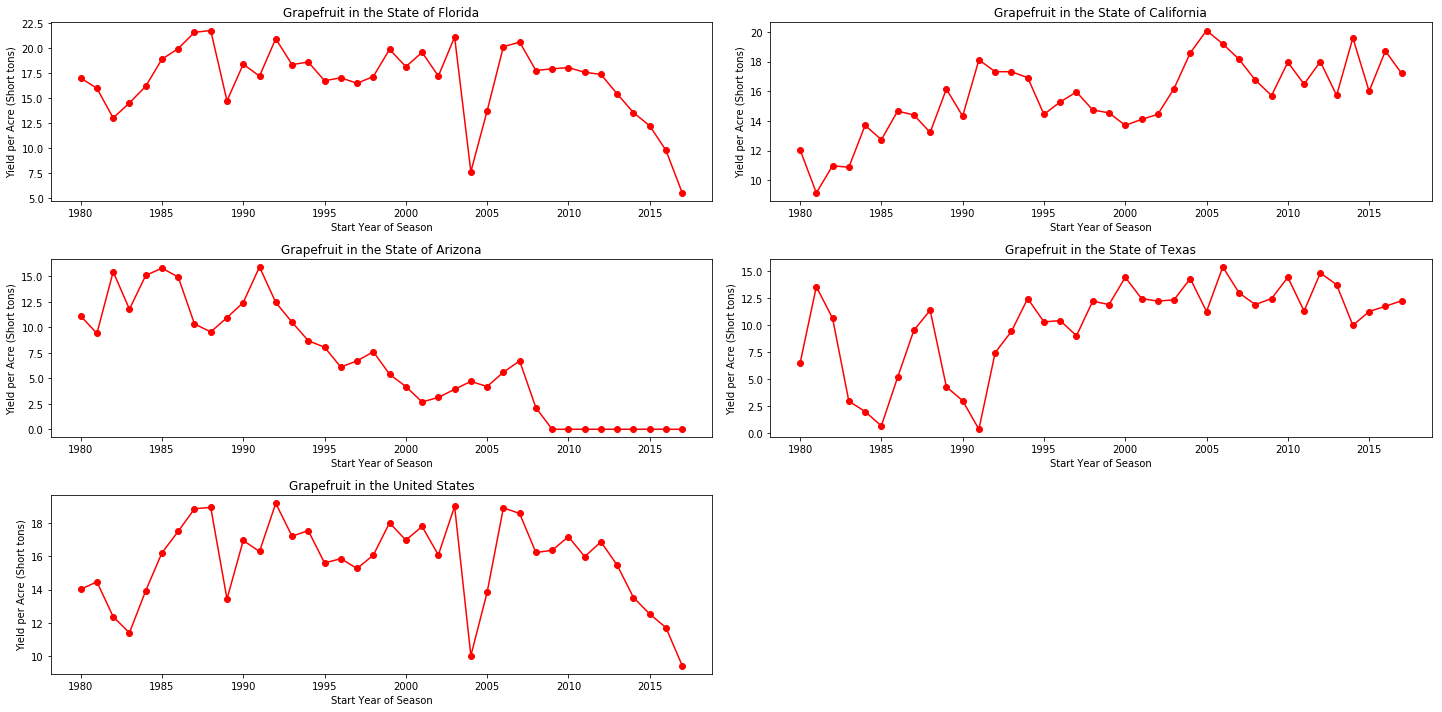

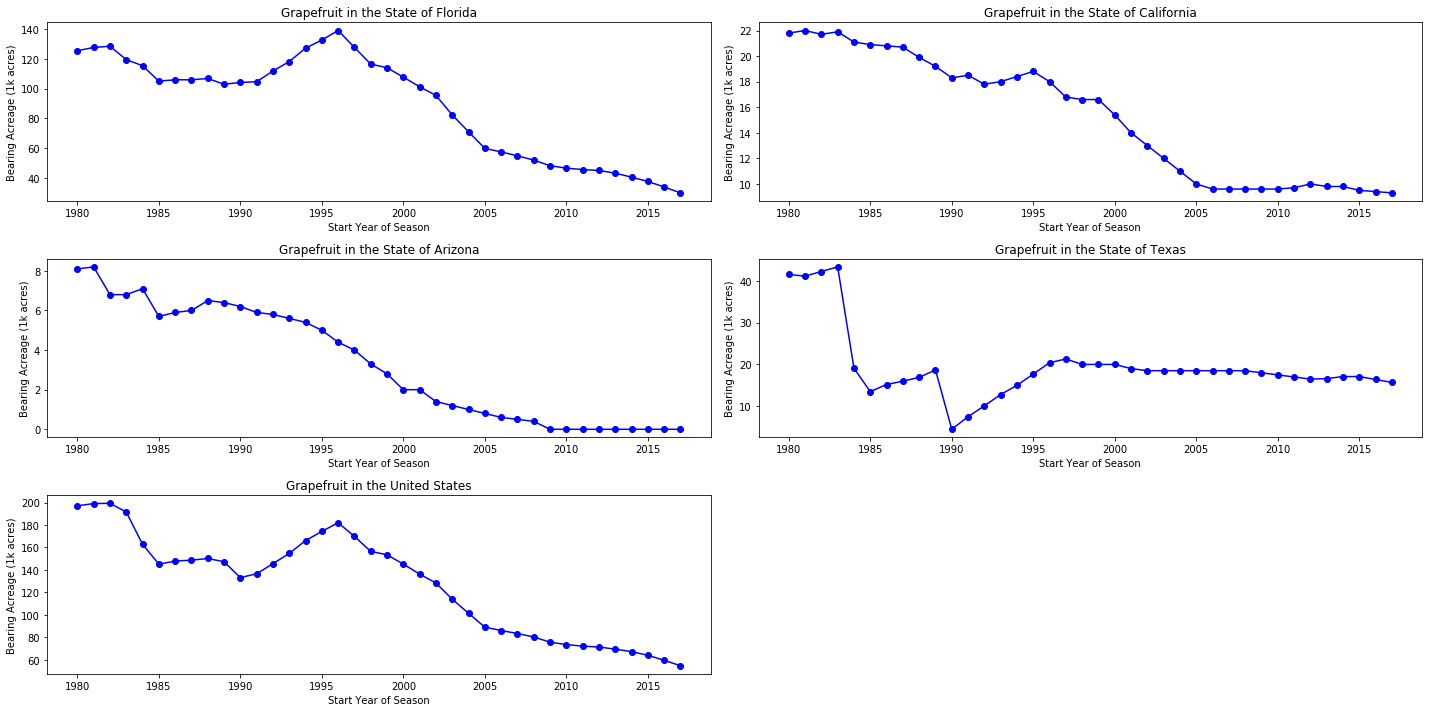

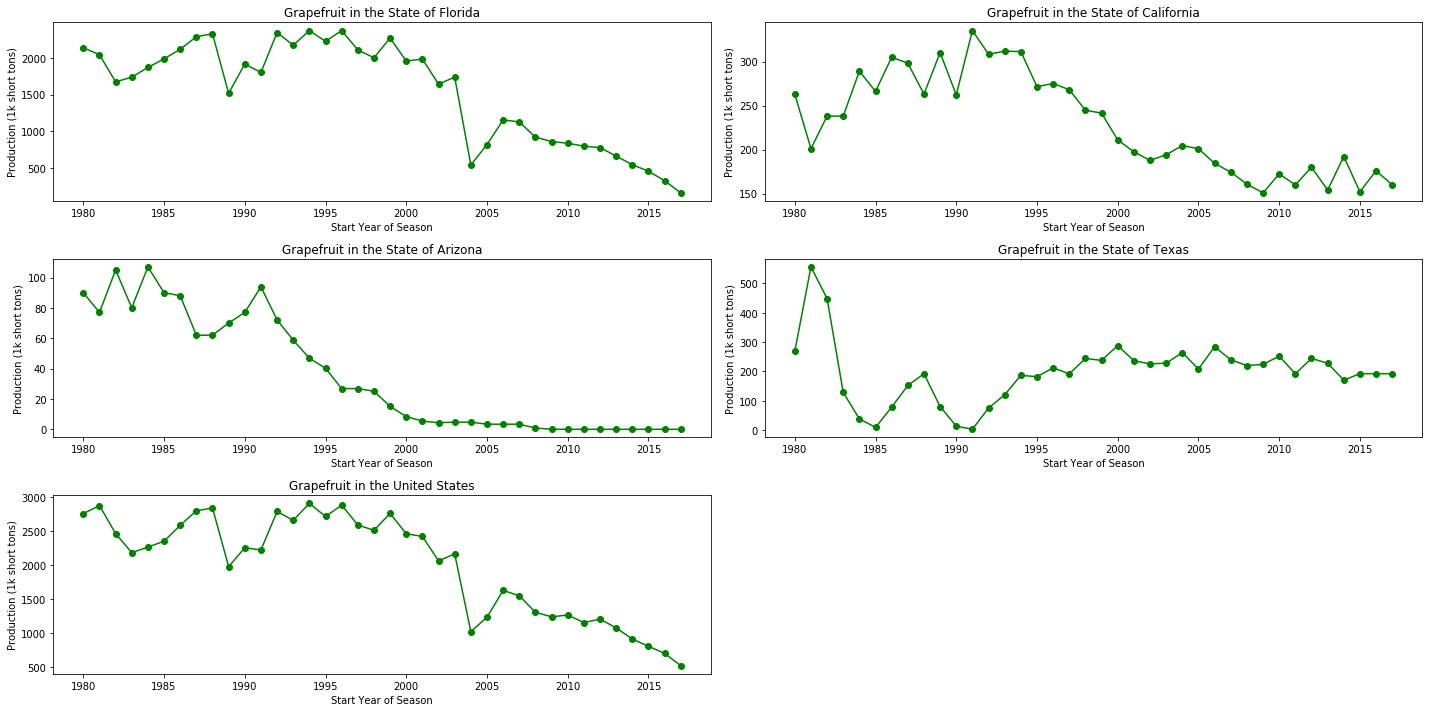

In [3]:
plot_time_series(cleaned_data_grapefruit, 'Grapefruit', YearbookPlotType.YIELD_PER_ACRE)
plot_time_series(cleaned_data_grapefruit, 'Grapefruit', YearbookPlotType.BEARING_ACREAGE)
plot_time_series(cleaned_data_grapefruit, 'Grapefruit', YearbookPlotType.PRODUCTION)

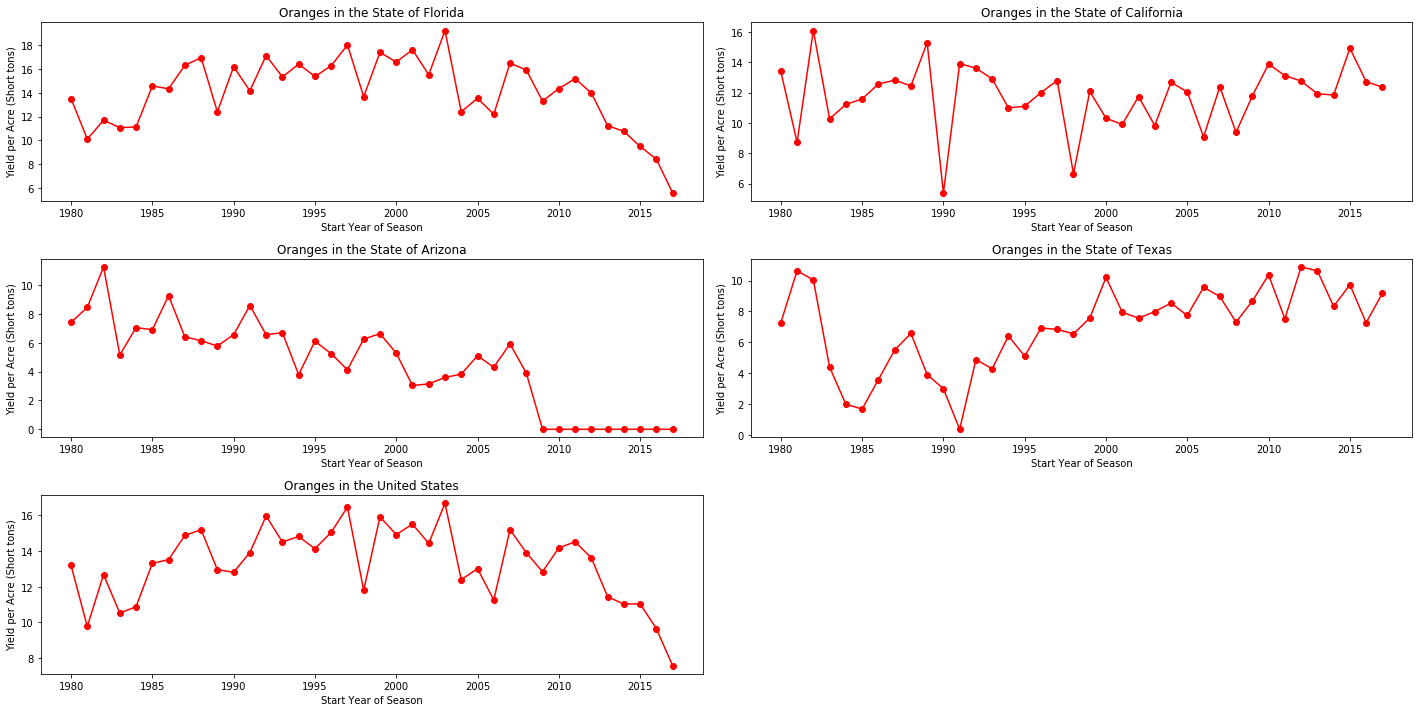

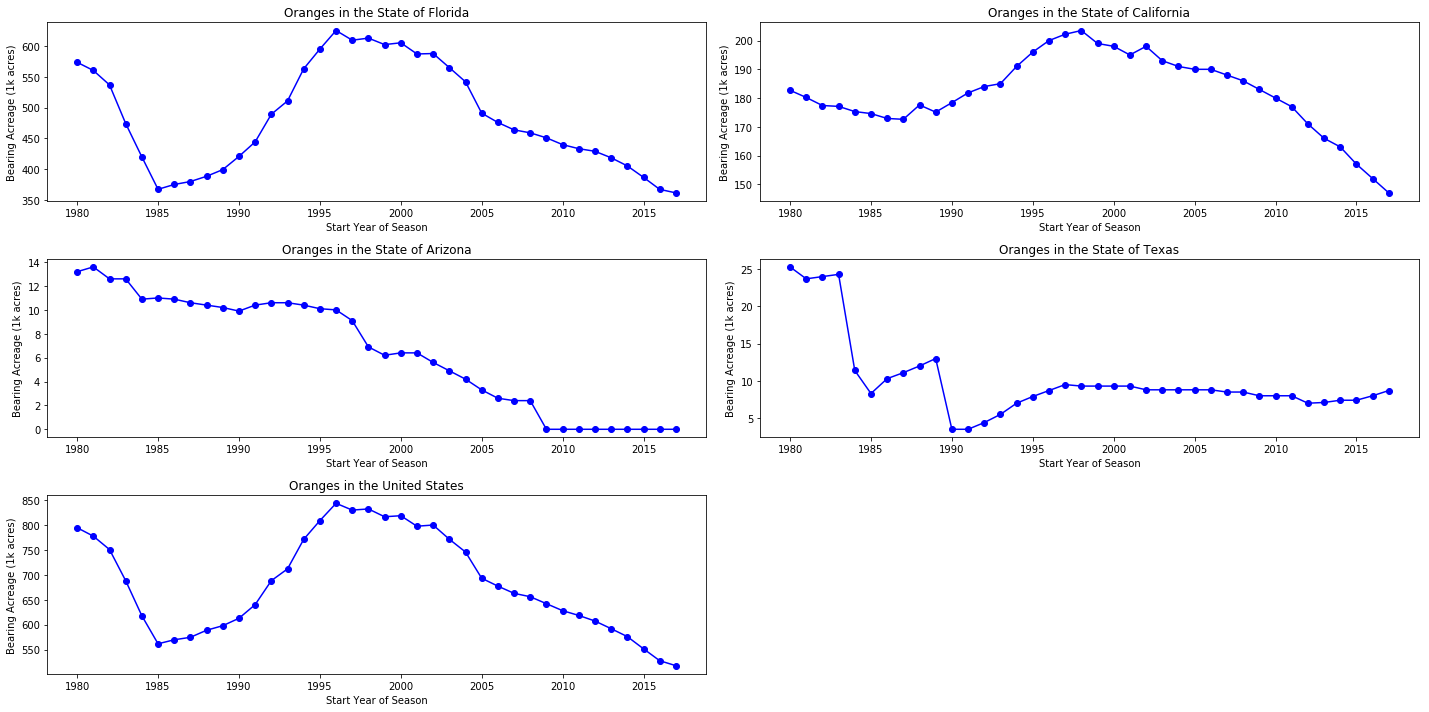

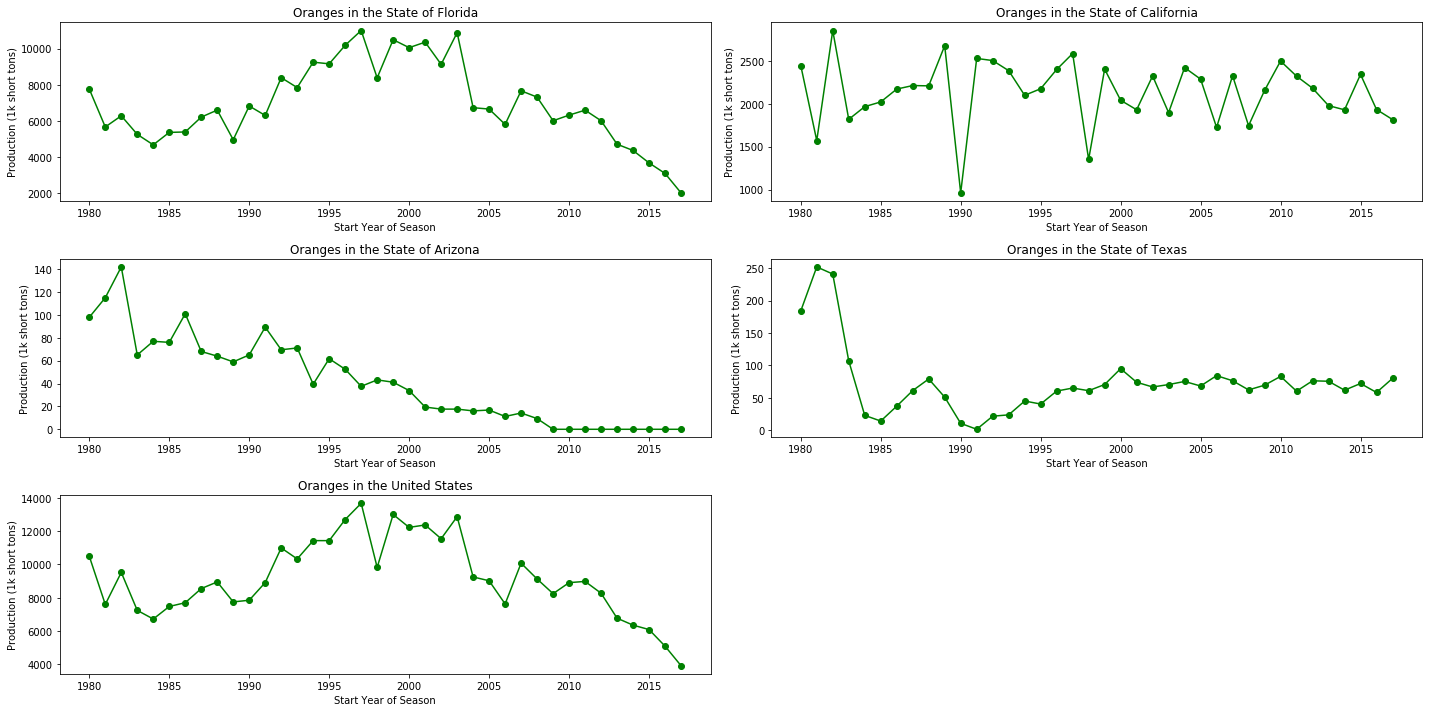

In [4]:
plot_time_series(cleaned_data_oranges, 'Oranges', YearbookPlotType.YIELD_PER_ACRE)
plot_time_series(cleaned_data_oranges, 'Oranges', YearbookPlotType.BEARING_ACREAGE)
plot_time_series(cleaned_data_oranges, 'Oranges', YearbookPlotType.PRODUCTION)

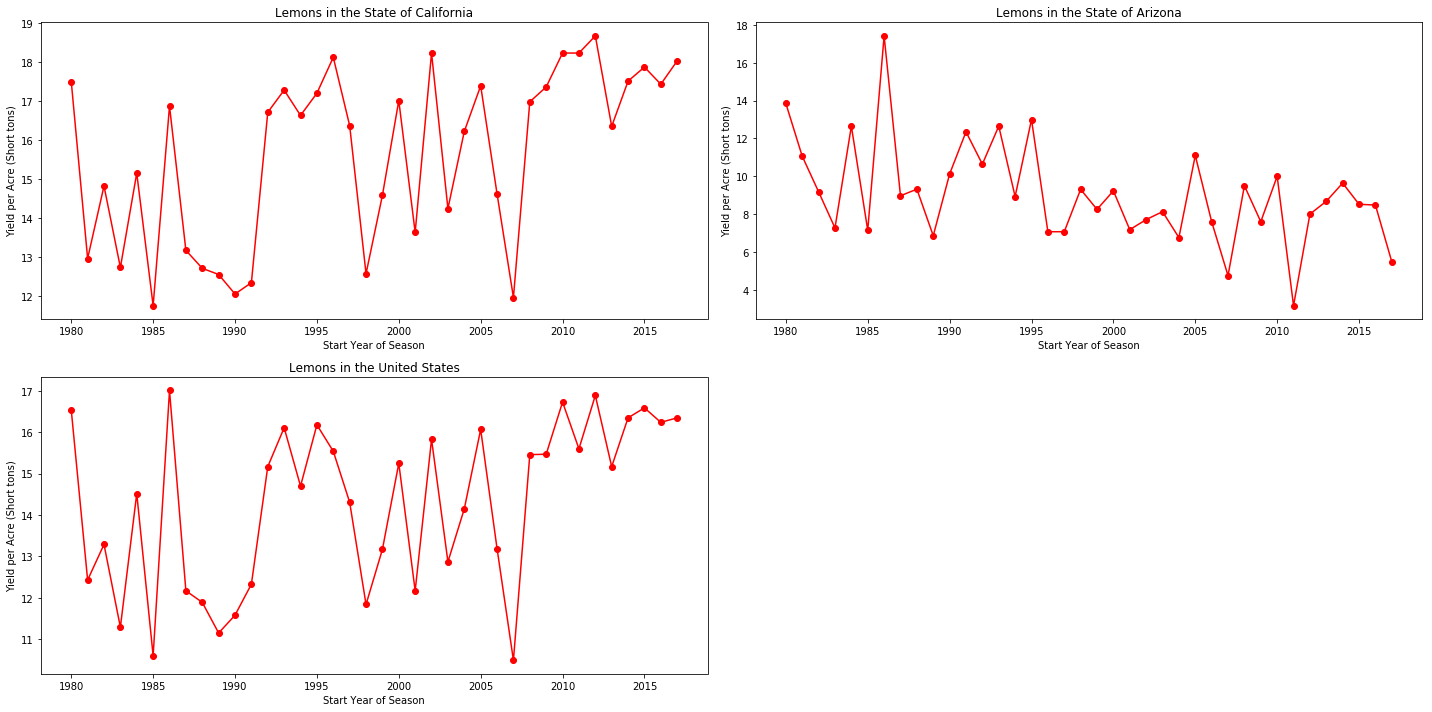

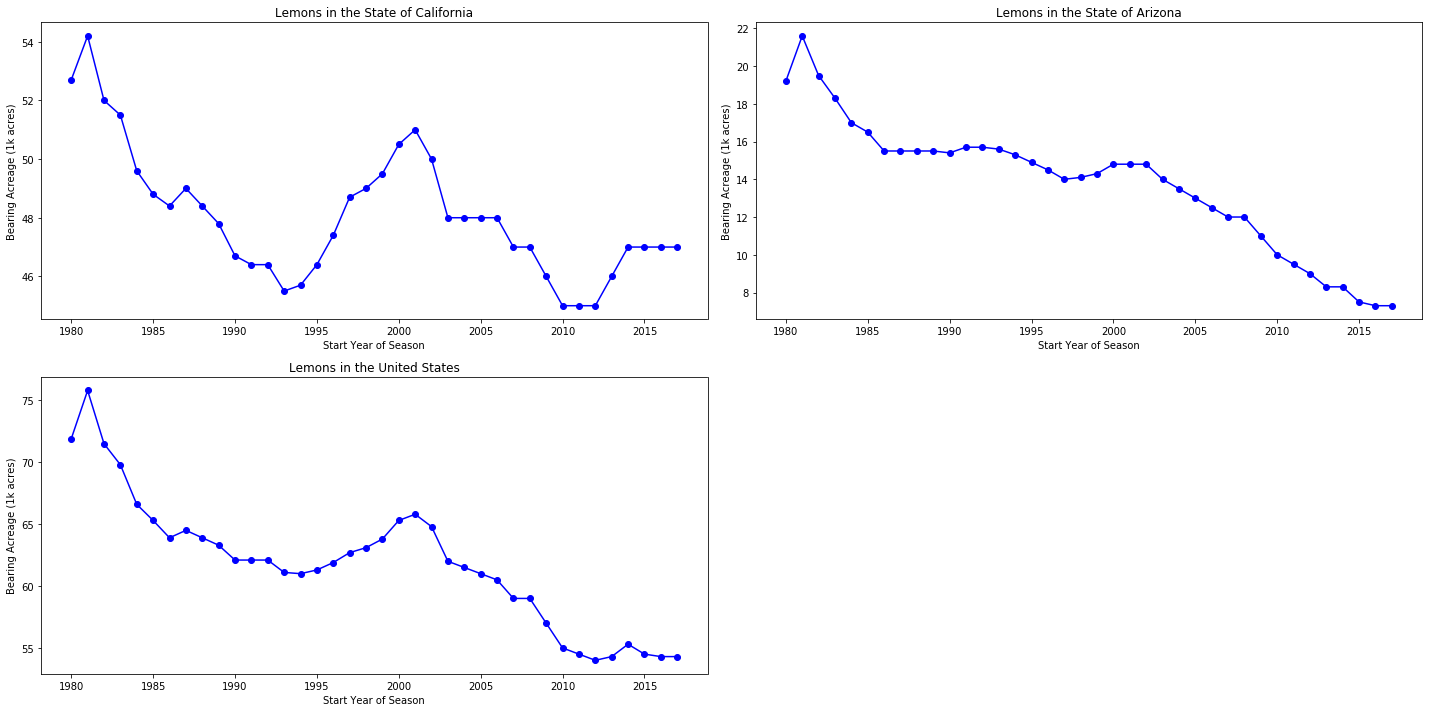

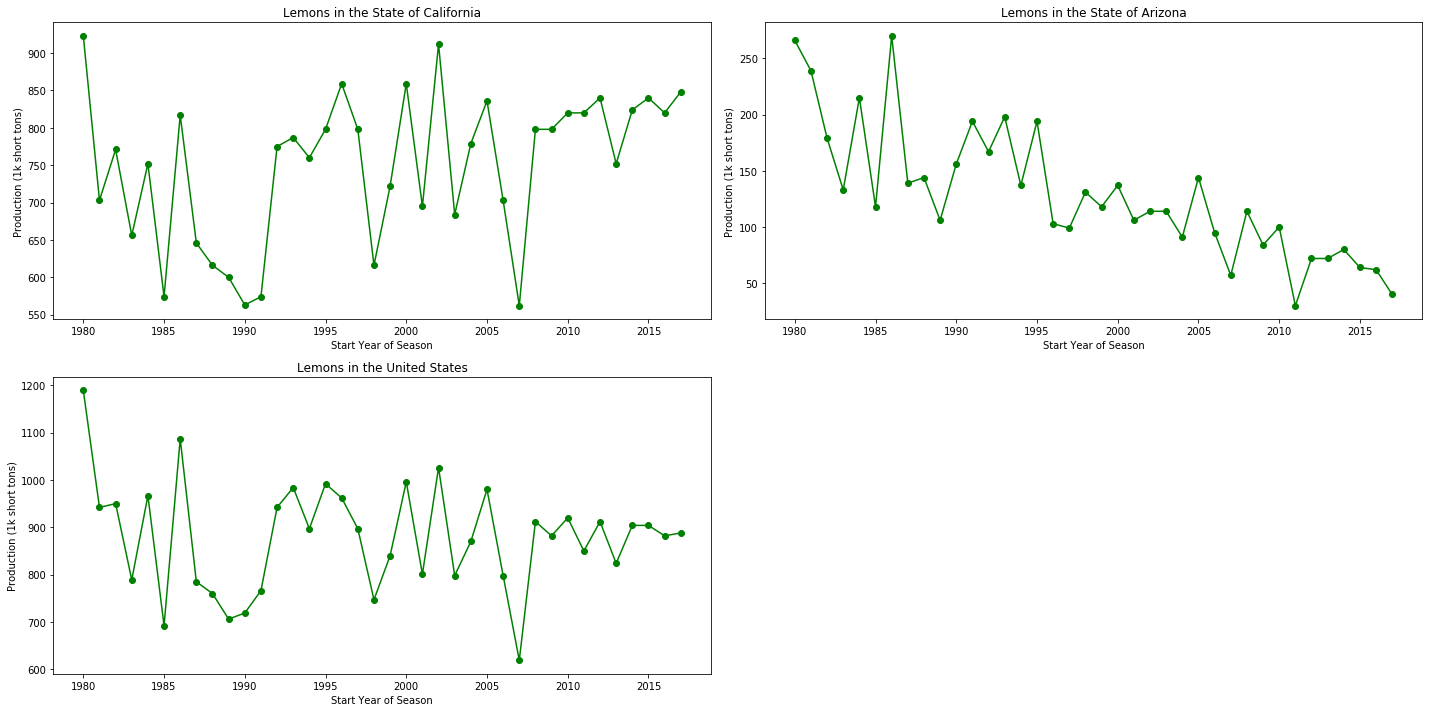

In [5]:
plot_time_series(cleaned_data_lemons, 'Lemons', YearbookPlotType.YIELD_PER_ACRE)
plot_time_series(cleaned_data_lemons, 'Lemons', YearbookPlotType.BEARING_ACREAGE)
plot_time_series(cleaned_data_lemons, 'Lemons', YearbookPlotType.PRODUCTION)

# Average Production of Citrus Crops by State

- Here we plot pie charts for each of the four states, showing the average production of each of the three major citrus crops (Lemons, Grapefruit, and Oranges) as a fraction of the total average production of each state.

- We see that of the four states highlighted by USDA as the major producers of citrus, only Arizona and California have production data for oranges, lemons, and grapefruit.

- In order to narrow the scope of our data analysis, we have decided to select only one of the four major citrus producing states to analyze more deeply, in trying to determine which extrinsic factors have contributed most significantly to the observed decline in citrus production over the past four decades.

- While both Arizona and California have historically produced enough of all three crops to warrant having the USDA report census information on them, in recent years, bearing acreage for both oranges and grapefruit have dropped to such a low level in the state of Arizona that the USDA is no longer those crops in its census reporting for Arizona.

- Therefore, we have decided to focus our analysis on citrus production in the state of California, because this state still produces enough of all three citrus crops to warrant having this production data reported by USDA.

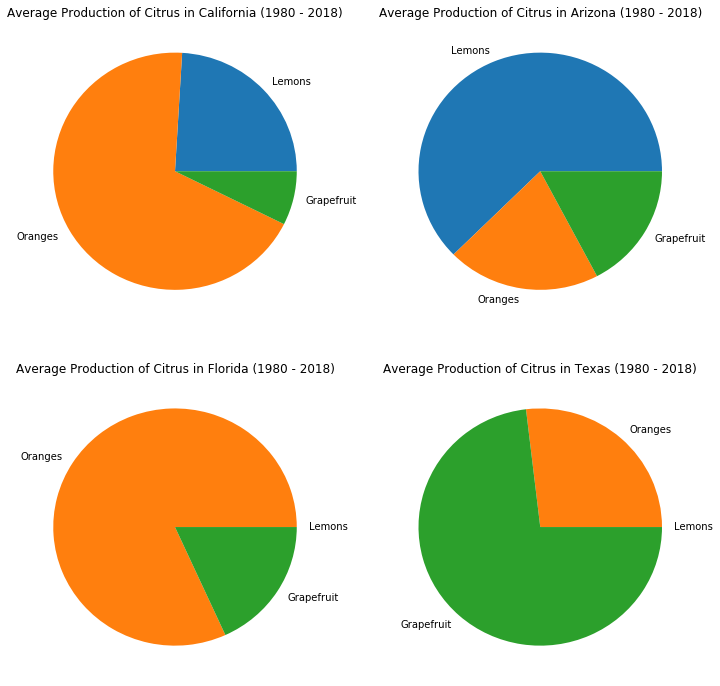

In [6]:
# Plot pie charts of average production for each of the major citrus crops, for each state

def average(items):
    
    if len(items) == 0:
        return len(items)
    
    return sum(items) / len(items)

states = ['California', 'Arizona', 'Florida', 'Texas']

curr_subplot = 1

plt.rcParams['figure.figsize'] = (12, 12)

for state in states:

    lemons_data_state = [row for row in cleaned_data_lemons if row[1] == state]
    oranges_data_state = [row for row in cleaned_data_oranges if row[1] == state]
    grapefruit_data_state = [row for row in cleaned_data_grapefruit if row[1] == state]

    lemons_production_state = [row[4] for row in lemons_data_state]
    oranges_production_state = [row[2] * row[3] for row in oranges_data_state]
    grapefruit_production_state = [row[2] * row[3] for row in grapefruit_data_state]

    avg_lemons_state = average(lemons_production_state)
    avg_oranges_state = average(oranges_production_state)
    avg_grapefruit_state = average(grapefruit_production_state)

    xs = [avg_lemons_state, avg_oranges_state, avg_grapefruit_state]

    plt.subplot(2, 2, curr_subplot)
    plt.pie(xs, labels=["Lemons", "Oranges", "Grapefruit"])
    curr_subplot += 1
    plt.title('Average Production of Citrus in ' + state + ' (1980 - 2018)')
    
plt.show()

In [7]:
from pathlib import Path
import csv
import codecs

# helper function which reads the csv_files containing lcd data
def read_ncdc_weather_data():
    csv_reads = []
    csv_files = []
    p = Path('./ncdc/lcd/california')
    
    for x in p.iterdir():  
        if x.is_dir():
            county_path = Path(x)  
            for x in county_path.iterdir():
                if x.is_file():
                    csv_files.append(x)
    for file in csv_files:
        if str(file)[-3:] == '.csv':
            print('reading ' + str(file))
            with codecs.open(str(file), 'rb', 'utf-8') as csv_file:
                file_data = []
                reader = csv.reader(csv_file)
                for row in reader:
                    file_data.append(row)
                csv_reads.append(file_data)
    return csv_reads
            
                            
csv_reads = read_ncdc_weather_data()
    

# Aggregating Weather Station Readings for the State of California
According to [an article](https://apps1.cdfa.ca.gov/FertilizerResearch/docs/Citrus_Production_CA.pdf) released by the California Department of Food and Agriculture, and dated June 2016, the top citrus producing counties in the state of California are:
- Fresno
- Kern
- Tulare
- Ventura
- Riverside

Here we aggregate temperature and humidity readings, gathered from weather stations in each the five counties highlighted above, using SQL commands.
The raw data is comprised of hourly sensor readings of Dry Bulb Temperature, and Relative Humidity, as well as numerous other weather metrics.
We aggregate the data into daily/monthly/yearly averages, maximums, and minimums.
We also generate a few other yearly metrics, including the following:

- Temperature range (max - min)
- Number of days with temperatures 10 degrees above the yearly average, by year
- Number of days with temperatures 10 degrees below the yearly average, by year
- Number of days with minimum temperatures below 32 degrees, by year
- Number of days with minimum temperatures within 3 degrees of the monthly minimum, in months with extreme lows, by year
- Number of days with temperatures 7 degrees above the monthly average, by year
- Number of days with temperatures 7 degrees below the monthly average, by year
- Number of days with relative humidity 15% or more above the monthly average, by year
- Number of days with relative humidity 25% or more above the yearly average


In [8]:
import sqlite3
from sqlite3 import Error

# fetch the weather station readings gathered from the ncdc by county
counties = ['Fresno', 'Ventura', 'Kern', 'Riverside', 'Tulare']
selections_average_daily = 'STATION_NAME, date(DATE) as DT, AVG(HOURLYDRYBULBTEMPF), AVG(HOURLYRelativeHumidity)'
group_by_average_daily = ' GROUP BY DT'
selections_average_yearly = 'STATION_NAME, substr(DATE, 1, 4) as YEAR, AVG(HOURLYDRYBULBTEMPF), AVG(HOURLYRelativeHumidity)'
group_by_average_yearly = ' GROUP BY YEAR'
queries = [
    (selections_average_daily, group_by_average_daily), 
    (selections_average_yearly, group_by_average_yearly),
]
data_collections = []

for county in counties:
    county_fetch = [county]
    conn = sqlite3.connect('./ncdc/lcd/california/' + county + '/' + county.lower() + '.db')
    cursor = conn.cursor()
    cursor.execute('SELECT name from sqlite_master WHERE type = "table"')
    tables = cursor.fetchall()
    for (table, ) in tables:
        for select, group in queries:
            cursor.execute('SELECT ' + select + ' FROM ' + table + group)
            county_fetch.append(cursor.fetchall())
    data_collections.append(county_fetch)
    
#conn = sqlite3.connect('./ncdc/lcd/california/Fresno/fresno.db')

#cursor = conn.cursor()

#cursor.execute('SELECT ' + selections + 'FROM fresno00_09 GROUP BY date(DATE)')
#data = cursor.fetchall()
print(len(data_collections))

fresno_data = data_collections[0]
ventura_data = data_collections[1]
kern_data = data_collections[2]
riverside_data = data_collections[3]
tulare_data = data_collections[4]

conn.close()

5


In [9]:
# aggregate yearly, monthly, and daily average temperature and humidity readings for the state of california
conn = sqlite3.connect('./ncdc/lcd/california/california.db')
cursor = conn.cursor()
cursor.execute('SELECT substr(DATE, 1, 4) as YEAR, AVG(CAST(HOURLYDRYBULBTEMPF as decimal)), \
AVG(CAST(HOURLYRelativeHumidity as decimal)) FROM \
(SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM fresno \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM kern \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM tulare \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM riverside_march \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM riverside_mun \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM ventura) \
GROUP BY YEAR')
california_yearly_averages = cursor.fetchall()

cursor.execute('SELECT date(DATE) as DT, AVG(CAST(HOURLYDRYBULBTEMPF as decimal)), \
AVG(CAST(HOURLYRelativeHumidity as decimal)) FROM \
(SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM fresno \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM kern \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM tulare \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM riverside_march \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM riverside_mun \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM ventura) \
GROUP BY DT')
california_daily_averages = cursor.fetchall()

cursor.execute('SELECT substr(DATE, 1, 7) as MONTH, AVG(CAST(HOURLYDRYBULBTEMPF as decimal)), \
AVG(CAST(HOURLYRelativeHumidity as decimal)) FROM \
(SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM fresno \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM kern \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM tulare \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM riverside_march \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM riverside_mun \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM ventura) \
GROUP BY MONTH')
california_monthly_averages = cursor.fetchall()

cursor.close()
print(california_yearly_averages)

[('2000', 62.37925576814857, 65.337120146314), ('2001', 63.04289176941722, 64.42118944743036), ('2002', 62.5106013208203, 62.918143899895725), ('2003', 63.99135283944517, 64.95768185508065), ('2004', 63.18294237194723, 61.40622093624057), ('2005', 63.15528465324701, 64.59716317061553), ('2006', 62.620637370010066, 60.94749412948675), ('2007', 61.581198428025445, 57.75716774481073), ('2008', 62.33091639389158, 60.744904213560076), ('2009', 61.83883459339849, 62.164919259239745), ('2010', 61.20380897058213, 66.41962297553351), ('2011', 60.806963904435825, 63.793811828024914), ('2012', 63.161073658238735, 60.53043651634288), ('2013', 64.39047867878604, 52.06764208412976), ('2014', 66.28551077496891, 54.66566514711977), ('2015', 65.55001862891207, 57.40092080051097), ('2016', 64.39263922206301, 60.473363064092865), ('2017', 64.56373150720331, 61.70871826345371), ('2018', 66.0563915431495, 57.87598751034535)]


In [10]:
# aggregate yearly, monthly, and daily maximum temperature and humidity readings for the state of california
conn = sqlite3.connect('./ncdc/lcd/california/california.db')
cursor = conn.cursor()
cursor.execute('SELECT substr(DATE, 1, 4) as YEAR, MAX(CAST(HOURLYDRYBULBTEMPF as integer)), \
MAX(CAST(HOURLYRelativeHumidity as integer)) FROM \
(SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM fresno \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM kern \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM tulare \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM riverside_march \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM riverside_mun \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM ventura) \
GROUP BY YEAR')
california_yearly_max = cursor.fetchall()

cursor.execute('SELECT date(DATE) as DT, MAX(CAST(HOURLYDRYBULBTEMPF as integer)), \
MAX(CAST(HOURLYRelativeHumidity as integer)) FROM \
(SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM fresno \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM kern \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM tulare \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM riverside_march \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM riverside_mun \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM ventura) \
GROUP BY DT')
california_daily_max = cursor.fetchall()

cursor.execute('SELECT substr(DATE, 1, 7) as MONTH, MAX(CAST(HOURLYDRYBULBTEMPF as integer)), \
MAX(CAST(HOURLYRelativeHumidity as integer)) FROM \
(SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM fresno \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM kern \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM tulare \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM riverside_march \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM riverside_mun \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM ventura) \
GROUP BY MONTH')
california_monthly_max = cursor.fetchall()

cursor.close()
print(california_yearly_max)

[('2000', 108, 100), ('2001', 110, 100), ('2002', 108, 100), ('2003', 108, 100), ('2004', 106, 100), ('2005', 108, 100), ('2006', 113, 100), ('2007', 110, 100), ('2008', 112, 107), ('2009', 110, 100), ('2010', 113, 100), ('2011', 107, 100), ('2012', 110, 102), ('2013', 110, 100), ('2014', 109, 100), ('2015', 109, 100), ('2016', 113, 100), ('2017', 111, 100), ('2018', 117, 100)]


In [11]:
# aggregate yearly, monthly, and daily minimum temperature and humidity readings for the state of california
conn = sqlite3.connect('./ncdc/lcd/california/california.db')
cursor = conn.cursor()
cursor.execute('SELECT substr(DATE, 1, 4) as YEAR, MIN(CAST(HOURLYDRYBULBTEMPF as integer)), \
MIN(CAST(HOURLYRelativeHumidity as integer)) FROM \
(SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM fresno \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM kern \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM tulare \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM riverside_march \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM riverside_mun \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM ventura) \
GROUP BY YEAR')
california_yearly_min = cursor.fetchall()

cursor.execute('SELECT date(DATE) as DT, MIN(CAST(HOURLYDRYBULBTEMPF as integer)), \
MIN(CAST(HOURLYRelativeHumidity as integer))FROM \
(SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM fresno \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM kern \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM tulare \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM riverside_march \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM riverside_mun \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM ventura) \
GROUP BY DT')
california_daily_min = cursor.fetchall()

cursor.execute('SELECT substr(DATE, 1, 7) as MONTH, MIN(CAST(HOURLYDRYBULBTEMPF as integer)), \
MIN(CAST(HOURLYRelativeHumidity as integer)) FROM \
(SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM fresno \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM kern \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM tulare \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM riverside_march \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM riverside_mun \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM ventura) \
GROUP BY MONTH')
california_monthly_min = cursor.fetchall()

cursor.close()

In [12]:
print(california_yearly_min)
print(california_monthly_min[:24])


[('2000', 27, 6), ('2001', 30, 5), ('2002', 28, 7), ('2003', 30, 8), ('2004', 26, 6), ('2005', 30, 5), ('2006', 27, 3), ('2007', 19, 3), ('2008', 25, 2), ('2009', 25, 3), ('2010', 23, 4), ('2011', 23, 2), ('2012', 25, 2), ('2013', 22, 2), ('2014', 27, 2), ('2015', 23, 4), ('2016', 18, 3), ('2017', 7, 2), ('2018', 20, 3)]
[('2000-01', 27, 16), ('2000-02', 35, 12), ('2000-03', 37, 14), ('2000-04', 41, 11), ('2000-05', 43, 12), ('2000-06', 48, 13), ('2000-07', 52, 11), ('2000-08', 54, 12), ('2000-09', 53, 13), ('2000-10', 44, 12), ('2000-11', 31, 13), ('2000-12', 29, 6), ('2001-01', 30, 5), ('2001-02', 30, 13), ('2001-03', 38, 27), ('2001-04', 36, 17), ('2001-05', 45, 9), ('2001-06', 50, 8), ('2001-07', 50, 12), ('2001-08', 54, 13), ('2001-09', 48, 13), ('2001-10', 48, 17), ('2001-11', 34, 19), ('2001-12', 32, 11)]


In [13]:
days_below_yearly_average_temp = []
days_above_yearly_average_temp = []
days_below_monthly_average_temp = []
days_above_monthly_average_temp = []
days_min_temp_below_32 = []
days_min_temp_close_monthly_min = []

In [14]:
# days in which the temperature was 10 degrees or more below the yearly average, and 10 degrees or more above the yearly average
for year, ytemp, yhumidity in california_yearly_averages:
    current_year = [year]
    
    days_below = [(date, temp, humidity) for (date, temp, humidity) in california_daily_averages if date[:4] == year and temp < ytemp - 10]
    days_below_yearly_average_temp.append(current_year + [len(days_below)])
    
    days_above = [(date, temp, humidity) for (date, temp, humidity) in california_daily_averages if date[:4] == year and temp > ytemp + 10]
    days_above_yearly_average_temp.append(current_year + [len(days_above)])

print(days_above_yearly_average_temp)
print(days_below_yearly_average_temp)

monthly_lows_dict = dict([(year, 0) for (year, temp, humidity) in california_yearly_averages])
monthly_highs_dict = dict([(year, 0) for (year, temp, humidity) in california_yearly_averages])

# days in which the temperature was 7 degrees or more below the monthly average, and 7 degrees or more above the monthly average
for month, mtemp, mhumidity in california_monthly_averages:
    days_below = [(date, temp, humidity) for (date, temp, humidity) in california_daily_averages if date[:7] == month and temp < mtemp - 7]
    days_above = [(date, temp, humidity) for (date, temp, humidity) in california_daily_averages if date[:7] == month and temp > mtemp + 7]
    
    monthly_lows_dict[month[:4]] += len(days_below)
    monthly_highs_dict[month[:4]] += len(days_above)

print(monthly_lows_dict)
print(monthly_highs_dict)

# number of days in which the min temperature was within 3 degrees of the monthly low, with a monthly low < 32, by year
monthly_extremes_dict = dict([(year, 0) for (year, _, _) in california_yearly_averages])

for month, mtemp, mhumidity in california_monthly_min:
    
    days_within_range = [(date, temp, _) for (date, temp, _) in california_daily_min if date[:7] == month and temp < mtemp + 3 and mtemp < 32]
    monthly_extremes_dict[month[:4]] += len(days_within_range)

print(monthly_extremes_dict)

# days in which the average humidity was 15% or more above the monthly average, grouped by year
monthly_humidity_highs_dict = dict([(year, 0) for (year, _, _) in california_yearly_averages])

for month, _, mhumidity in california_monthly_averages:
    days_above = [(date, _, humidity) for (date, _, humidity) in california_daily_averages if date[:7] == month and humidity >= mhumidity + 15]
    monthly_humidity_highs_dict[month[:4]] += len(days_above)

print(monthly_humidity_highs_dict)

# days in which the average humidity was 25% or more above the yearly average, grouped by year
yearly_humidity_highs_dict = dict([(year, 0) for (year, _, _) in california_yearly_averages])

for year, _, yhumidity in california_yearly_averages:
    days_above = [(date, _, humidity) for (date, _, humidity) in california_daily_averages if date[:4] == year and humidity >= yhumidity + 25]
    yearly_humidity_highs_dict[year] += len(days_above)

print(yearly_humidity_highs_dict)
    
# days in which the minimum temperature was below 32 degrees fahrenheit
for year, ytemp, yhumidity in california_yearly_averages:
    current_year = [year]
    
    days_below = [(date, temp, humidity) for (date, temp, humidity) in california_daily_min if date[:4] == year and temp < 32]
    days_min_temp_below_32.append(current_year + [len(days_below)])
print(days_min_temp_below_32)


[['2000', 102], ['2001', 107], ['2002', 105], ['2003', 105], ['2004', 98], ['2005', 76], ['2006', 100], ['2007', 95], ['2008', 109], ['2009', 101], ['2010', 83], ['2011', 103], ['2012', 102], ['2013', 92], ['2014', 96], ['2015', 101], ['2016', 91], ['2017', 92], ['2018', 70]]
[['2000', 85], ['2001', 98], ['2002', 71], ['2003', 98], ['2004', 94], ['2005', 58], ['2006', 92], ['2007', 84], ['2008', 89], ['2009', 78], ['2010', 70], ['2011', 92], ['2012', 87], ['2013', 77], ['2014', 73], ['2015', 94], ['2016', 69], ['2017', 76], ['2018', 59]]
{'2000': 21, '2001': 15, '2002': 20, '2003': 17, '2004': 27, '2005': 9, '2006': 22, '2007': 23, '2008': 13, '2009': 14, '2010': 21, '2011': 16, '2012': 21, '2013': 22, '2014': 24, '2015': 26, '2016': 21, '2017': 23, '2018': 15}
{'2000': 28, '2001': 24, '2002': 21, '2003': 16, '2004': 21, '2005': 9, '2006': 25, '2007': 21, '2008': 22, '2009': 27, '2010': 31, '2011': 19, '2012': 17, '2013': 24, '2014': 19, '2015': 24, '2016': 21, '2017': 25, '2018': 10}


# Generating Pandas Dataframes with Combined Agricultural and Weather Data, By Year
Now that we have generated the aggregate weather metrics for the state of California, we are ready to combine the citrus agricultural data and that weather data into a single Pandas Dataframe. Here, we generate separate such pandas dataframes for each of the citrus crops analyzed in this study: Lemons, Grapefruits, and Oranges.
- First we pull out all of the citrus data for the state of California, and then we group it with the weather data by year
- We pull a list of each of the summary statistics generated from the weather data, to be added to columns in our data frames
- Having the data aggregated into Dataframes will make plotting and analyzing the relationships between the agricultural and weather data much simpler.


In [15]:
california_data_grapefruit = [
    (date[1:][:4], ypa, ba, ypa * ba) 
    for [date, state, ba, ypa] in cleaned_data_grapefruit 
    if state == 'California' and int(date[1:][:4]) >= 2000
]
california_data_oranges = [
    (date[1:][:4], ypa, ba, ypa * ba) 
    for [date, state, ba, ypa] in cleaned_data_oranges 
    if state == 'California' and int(date[1:][:4]) >= 2000
]
california_data_lemons = [
    (date[1:][:4], ypa, ba, prod) 
    for [date, state, ba, ypa, prod] in cleaned_data_lemons 
    if state == 'California' and int(date[1:][:4]) >= 2000
]
print(california_data_lemons)

[('2000', 17.02, 50.5, 859.0), ('2001', 13.64, 51.0, 695.0), ('2002', 18.24, 50.0, 912.0), ('2003', 14.25, 48.0, 684.0), ('2004', 16.23, 48.0, 779.0), ('2005', 17.4, 48.0, 836.0), ('2006', 14.63, 48.0, 703.0), ('2007', 11.97, 47.0, 562.0), ('2008', 16.99, 47.0, 798.0), ('2009', 17.37, 46.0, 798.0), ('2010', 18.24, 45.0, 820.0), ('2011', 18.24, 45.0, 820.0), ('2012', 18.68, 45.0, 840.0), ('2013', 16.36, 46.0, 752.0), ('2014', 17.52, 47.0, 824.0), ('2015', 17.88, 47.0, 840.0), ('2016', 17.44, 47.0, 820.0), ('2017', 18.04, 47.0, 848.0)]


In [81]:
import pandas as pd
# get data into lists so that they can be fed to the columns of a DataFrame via a dictionary
years = [int(year) for (year, _, _, _) in california_data_grapefruit]
ypa_grapefruit = [ypa for (_, ypa, _, _) in california_data_grapefruit]
ba_grapefruit = [ba for (_, _, ba, _) in california_data_grapefruit]
prod_grapefruit = [prod for (_, _, _, prod) in california_data_grapefruit]

ypa_oranges = [ypa for (_, ypa, _, _) in california_data_oranges]
ba_oranges = [ba for (_, _, ba, _) in california_data_oranges]
prod_oranges = [prod for (_, _, _, prod) in california_data_oranges]

ypa_lemons = [ypa for (_, ypa, _, _) in california_data_lemons]
ba_lemons = [ba for (_, _, ba, _) in california_data_lemons]
prod_lemons = [prod for (_, _, _, prod) in california_data_lemons]

yearly_average_temp = [temp for (year, temp, _) in california_yearly_averages if year != '2018']
yearly_min_temp = [temp for (year, temp, _) in california_yearly_min if year != '2018']
yearly_max_temp = [temp for (year, temp, _) in california_yearly_max if year != '2018']
yearly_temp_range = [
    max_temp - min_temp
    for (max_year, max_temp, _) in california_yearly_max
    for (min_year, min_temp, _) in california_yearly_min
    if max_year == min_year and max_year != '2018'
]
yearly_days_temp_below = [
    count for [year, count] in days_below_yearly_average_temp if year != '2018'
]
yearly_days_temp_above = [
    count for [year, count] in days_above_yearly_average_temp if year != '2018'
]
yearly_days_temp_below_monthly = [
    count for year, count in monthly_lows_dict.items() if year != '2018'
]
yearly_days_temp_above_monthly = [
    count for year, count in monthly_highs_dict.items() if year != '2018'
]
yearly_days_temp_extreme_monthly = [
    count for year, count in monthly_extremes_dict.items() if year != '2018'
]
yearly_days_temp_below_32 = [
    count for [year, count] in days_min_temp_below_32 if year != '2018'
]
yearly_days_humidity_above_monthly = [
    count for year, count in monthly_humidity_highs_dict.items() if year != '2018'
]
yearly_days_humidity_above_yearly = [
    count for year, count in yearly_humidity_highs_dict.items() if year != '2018'
]

grapefruit_data_dict = {
    'Year': years,
    'Yield Per Acre (Short Tons)': ypa_grapefruit,
    'Bearing Acreage (1k Acres)': ba_grapefruit,
    'Production (1k Short Tons)': prod_grapefruit,
    'Average Temp (F)': yearly_average_temp,
    'Min Temp (F)': yearly_min_temp,
    'Max Temp (F)': yearly_max_temp,
    'Temp Range (F)': yearly_temp_range,
    'Days Below Average Temp': yearly_days_temp_below,
    'Days Above Average Temp': yearly_days_temp_above,
    'Days Below Monthly Average Temp': yearly_days_temp_below_monthly,
    'Days Above Monthly Average Temp': yearly_days_temp_above_monthly,
    'Days With Temp Close to Monthly Extreme': yearly_days_temp_extreme_monthly,
    'Days with Temp Below Freezing': yearly_days_temp_below_32,
    'Days Above Monthly Average Humidity': yearly_days_humidity_above_monthly,
    'Days Above Average Humidity': yearly_days_humidity_above_yearly
}

grapefruit_df = pd.DataFrame.from_dict(grapefruit_data_dict)

oranges_data_dict = {
    'Year': years,
    'Yield Per Acre (Short Tons)': ypa_oranges,
    'Bearing Acreage (1k Acres)': ba_oranges,
    'Production (1k Short Tons)': prod_oranges,
    'Average Temp (F)': yearly_average_temp,
    'Min Temp (F)': yearly_min_temp,
    'Max Temp (F)': yearly_max_temp,
    'Temp Range (F)': yearly_temp_range,
    'Days Below Average Temp': yearly_days_temp_below,
    'Days Above Average Temp': yearly_days_temp_above,
    'Days Below Monthly Average Temp': yearly_days_temp_below_monthly,
    'Days Above Monthly Average Temp': yearly_days_temp_above_monthly,
    'Days With Temp Close to Monthly Extreme': yearly_days_temp_extreme_monthly,
    'Days with Temp Below Freezing': yearly_days_temp_below_32,
    'Days Above Monthly Average Humidity': yearly_days_humidity_above_monthly,
    'Days Above Average Humidity': yearly_days_humidity_above_yearly
}

oranges_df = pd.DataFrame.from_dict(oranges_data_dict)

lemons_data_dict = {
    'Year': years,
    'Yield Per Acre (Short Tons)': ypa_lemons,
    'Bearing Acreage (1k Acres)': ba_lemons,
    'Production (1k Short Tons)': prod_lemons,
    'Average Temp (F)': yearly_average_temp,
    'Min Temp (F)': yearly_min_temp,
    'Max Temp (F)': yearly_max_temp,
    'Temp Range (F)': yearly_temp_range,
    'Days Below Average Temp': yearly_days_temp_below,
    'Days Above Average Temp': yearly_days_temp_above,
    'Days Below Monthly Average Temp': yearly_days_temp_below_monthly,
    'Days Above Monthly Average Temp': yearly_days_temp_above_monthly,
    'Days With Temp Close to Monthly Extreme': yearly_days_temp_extreme_monthly,
    'Days with Temp Below Freezing': yearly_days_temp_below_32,
    'Days Above Monthly Average Humidity': yearly_days_humidity_above_monthly,
    'Days Above Average Humidity': yearly_days_humidity_above_yearly
}

lemons_df = pd.DataFrame.from_dict(lemons_data_dict)
lemons_df

,Year,Yield Per Acre (Short Tons),Bearing Acreage (1k Acres),Production (1k Short Tons),Average Temp (F),Min Temp (F),Max Temp (F),Temp Range (F),Days Below Average Temp,Days Above Average Temp,Days Below Monthly Average Temp,Days Above Monthly Average Temp,Days With Temp Close to Monthly Extreme,Days with Temp Below Freezing,Days Above Monthly Average Humidity,Days Above Average Humidity
0,2000,17.02,50.5,859.0,62.379256,27,108,81,85,102,21,28,11,9,11,6
1,2001,13.64,51.0,695.0,63.042892,30,110,80,98,107,15,24,11,6,3,9
2,2002,18.24,50.0,912.0,62.510601,28,108,80,71,105,20,21,11,11,11,16
3,2003,14.25,48.0,684.0,63.991353,30,108,78,98,105,17,16,3,2,8,13
4,2004,16.23,48.0,779.0,63.182942,26,106,80,94,98,27,21,10,11,6,19
5,2005,17.40,48.0,836.0,63.155285,30,108,78,58,76,9,9,5,3,10,5
6,2006,14.63,48.0,703.0,62.620637,27,113,86,92,100,22,25,25,30,10,2
7,2007,11.97,47.0,562.0,61.581198,19,110,91,84,95,23,21,15,41,20,7
8,2008,16.99,47.0,798.0,62.330916,25,112,87,89,109,13,22,13,27,12,20
9,2009,17.37,46.0,798.0,61.838835,25,110,85,78,101,14,27,22,32,21,9


# Analyzing the Effects of Temperature and Humidity Trends on Citrus Crop Yields in California

- Now that the yearly agricultural and weather data have been grouped into data frames, we are ready to analyze and try to elucidate any correlations/causal relationships between trends in temperature and humidity, and agricultural yields in the three citrus crops.
- Because Citrus crops in general are susceptible to damage by extremely cold temperatures, we would expect to see that years with lower extremes of temperature to experience lower yield per acre.
- Sense temperature/humidity regimes are more likely to put stress on existing citrus trees, as opposed to completely wiping them out and reducing bearing acreage, we would expect the decline in production reflected more so in the yield per acre than in the bearing acreage, or production which combines these two metrics.
- We start by generating pairwise pearson correlation statistics between the crop yield metrics, and the weather metrics, to try and highlight how strongly different weather metrics are linearly correlated with the crop trends.
- We also generate pairwise covariance coefficients to 

In [82]:
#grapefruit_df.plot.scatter(x='Min Temp (F)', y='Yield Per Acre (Short Tons)', s=50, title='Yearly Min Temp vs. Yield Per Acre in Grapefruits')
print('Correlation Matrix')
print(grapefruit_df.corr()[['Yield Per Acre (Short Tons)', 'Bearing Acreage (1k Acres)', 'Production (1k Short Tons)']])
print('\nCovariance Matrix')
print(grapefruit_df.cov()[['Yield Per Acre (Short Tons)', 'Bearing Acreage (1k Acres)', 'Production (1k Short Tons)']])

Correlation Matrix
                                         Yield Per Acre (Short Tons)  \
Year                                                        0.380350   
Yield Per Acre (Short Tons)                                 1.000000   
Bearing Acreage (1k Acres)                                 -0.681914   
Production (1k Short Tons)                                  0.082579   
Average Temp (F)                                            0.183774   
Min Temp (F)                                               -0.131489   
Max Temp (F)                                                0.227600   
Temp Range (F)                                              0.182606   
Days Below Average Temp                                    -0.359709   
Days Above Average Temp                                    -0.598326   
Days Below Monthly Average Temp                             0.106997   
Days Above Monthly Average Temp                            -0.430091   
Days With Temp Close to Monthly Extreme      

In [83]:
print('Correlation Matrix')
print(oranges_df.corr()[['Yield Per Acre (Short Tons)', 'Bearing Acreage (1k Acres)', 'Production (1k Short Tons)']])
print('\nCovariance Matrix')
print(oranges_df.cov()[['Yield Per Acre (Short Tons)', 'Bearing Acreage (1k Acres)', 'Production (1k Short Tons)']])

Correlation Matrix
                                         Yield Per Acre (Short Tons)  \
Year                                                        0.581246   
Yield Per Acre (Short Tons)                                 1.000000   
Bearing Acreage (1k Acres)                                 -0.550727   
Production (1k Short Tons)                                  0.730443   
Average Temp (F)                                            0.123682   
Min Temp (F)                                               -0.401122   
Max Temp (F)                                               -0.133989   
Temp Range (F)                                              0.294112   
Days Below Average Temp                                    -0.291800   
Days Above Average Temp                                    -0.434207   
Days Below Monthly Average Temp                             0.395445   
Days Above Monthly Average Temp                             0.025524   
Days With Temp Close to Monthly Extreme      

In [84]:
print('Correlation Matrix')
print(lemons_df.corr()[['Yield Per Acre (Short Tons)', 'Bearing Acreage (1k Acres)', 'Production (1k Short Tons)']])
print('\nCovariance Matrix')
print(lemons_df.cov()[['Yield Per Acre (Short Tons)', 'Bearing Acreage (1k Acres)', 'Production (1k Short Tons)']])

Correlation Matrix
                                         Yield Per Acre (Short Tons)  \
Year                                                        0.452786   
Yield Per Acre (Short Tons)                                 1.000000   
Bearing Acreage (1k Acres)                                 -0.377472   
Production (1k Short Tons)                                  0.941089   
Average Temp (F)                                            0.121183   
Min Temp (F)                                               -0.175544   
Max Temp (F)                                               -0.038535   
Temp Range (F)                                              0.135095   
Days Below Average Temp                                    -0.438081   
Days Above Average Temp                                    -0.185352   
Days Below Monthly Average Temp                            -0.004828   
Days Above Monthly Average Temp                             0.025244   
Days With Temp Close to Monthly Extreme      

Text(0,0.5,'Average Daily Humidity')

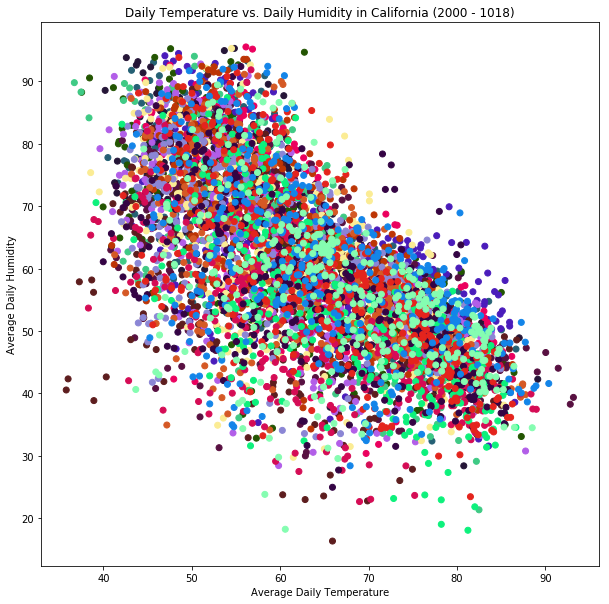

In [91]:
california_daily_dates = [date for (date, temp, humid) in california_daily_averages]
california_daily_temps = [temp for (date, temp, humid) in california_daily_averages]
california_daily_humids = [humid for (date, temp, humid) in california_daily_averages]
colors = [(np.random.random(), np.random.random(), np.random.random()) for data in california_yearly_averages]
color_dict = dict(list(zip([year for (year, temp, humid) in california_yearly_averages], colors)))
california_daily_colors = [color_dict[date[:4]] for (date, temp, humid) in california_daily_averages]

plt.rcParams['figure.figsize'] = (10, 10)
plt.scatter(california_daily_temps, california_daily_humids, c=california_daily_colors)
plt.title('Daily Temperature vs. Daily Humidity in California (2000 - 1018)')
plt.xlabel('Average Daily Temperature')
plt.ylabel('Average Daily Humidity')

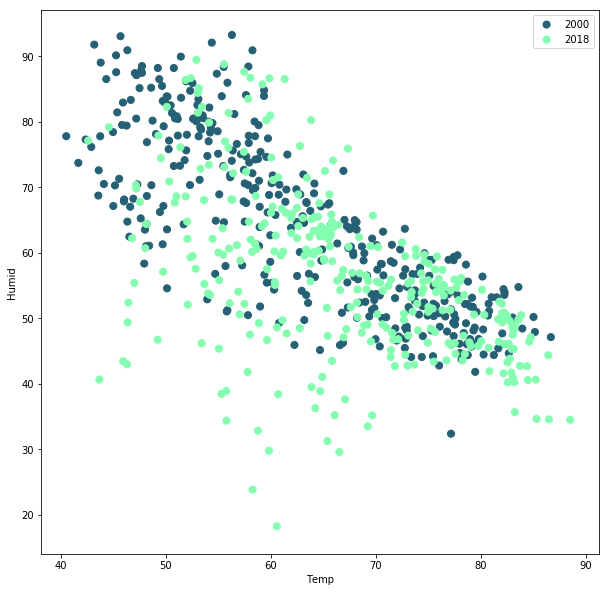

In [92]:
california_daily_dates_2000_2018 = [date for (date, temp, humid) in california_daily_averages if date[:4] == '2000' or date[:4] == '2018']
california_daily_temps_2000_2018 = [temp for (date, temp, humid) in california_daily_averages if date[:4] == '2000' or date[:4] == '2018']
california_daily_humids_2000_2018 = [humid for (date, temp, humid) in california_daily_averages if date[:4] == '2000' or date[:4] == '2018']
california_daily_averages_2000_2018 = [(date, temp, humid) for (date, temp, humid) in california_daily_averages if date[:4] == '2000' or date[:4] == '2018']
colors_2000 = [color_dict[date[:4]] for date in california_daily_dates_2000_2018 if date[:4] == '2000']
colors_2018 = [color_dict[date[:4]] for date in california_daily_dates_2000_2018 if date[:4] == '2018']
labels_2000_2018 = [date[:4] for date in california_daily_dates_2000_2018]

df = pd.DataFrame.from_dict(dict([('Year', labels_2000_2018), ('Temp', california_daily_temps_2000_2018), ('Humid', california_daily_humids_2000_2018)]))
ax = df.iloc[0:365].plot.scatter(x='Temp', y='Humid', label='2000', s=50, c=colors_2000)
df.iloc[365:].plot.scatter(x='Temp', y='Humid', label='2018', ax=ax, s=50, c=colors_2018)

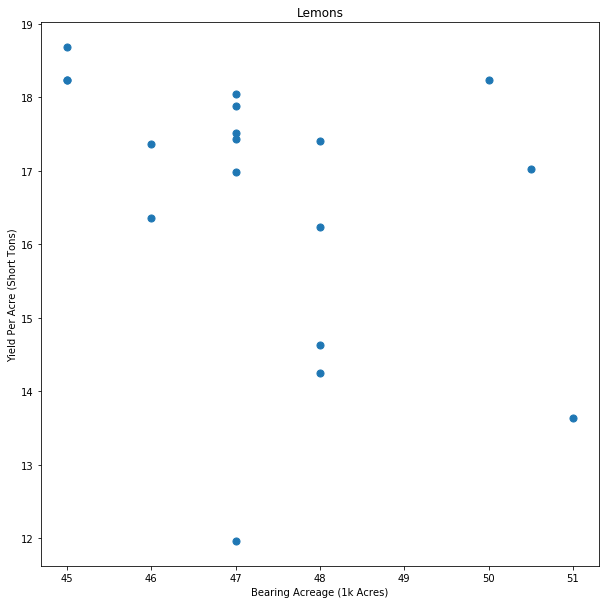

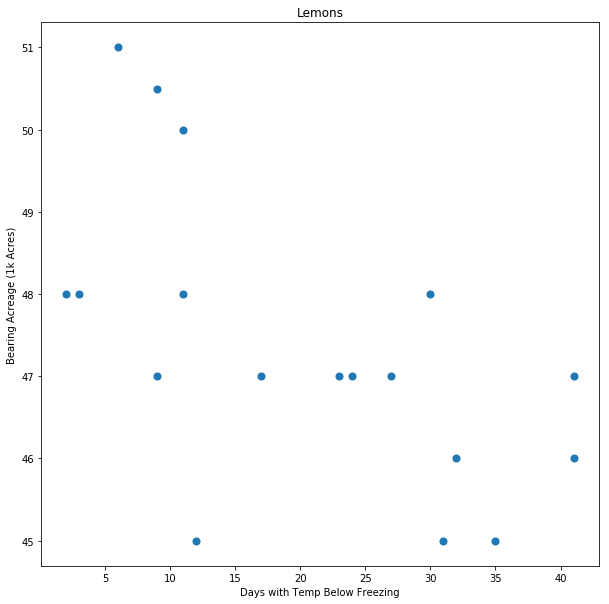

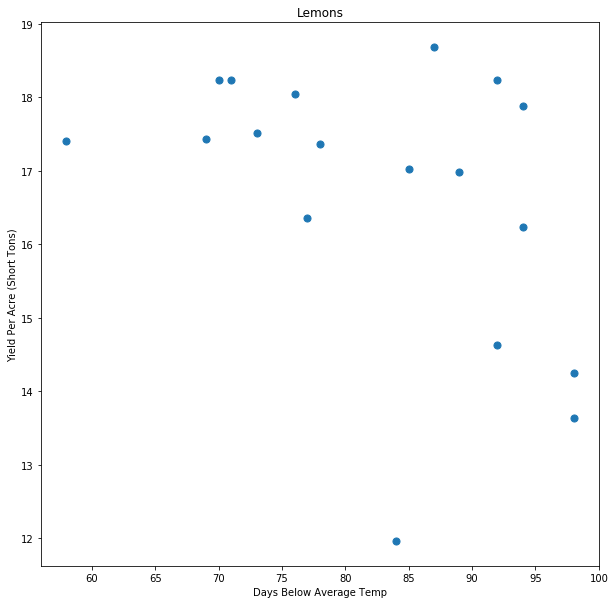

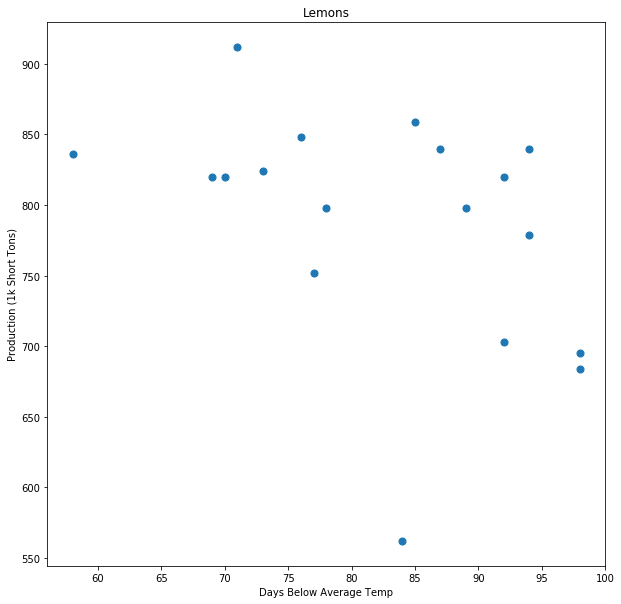

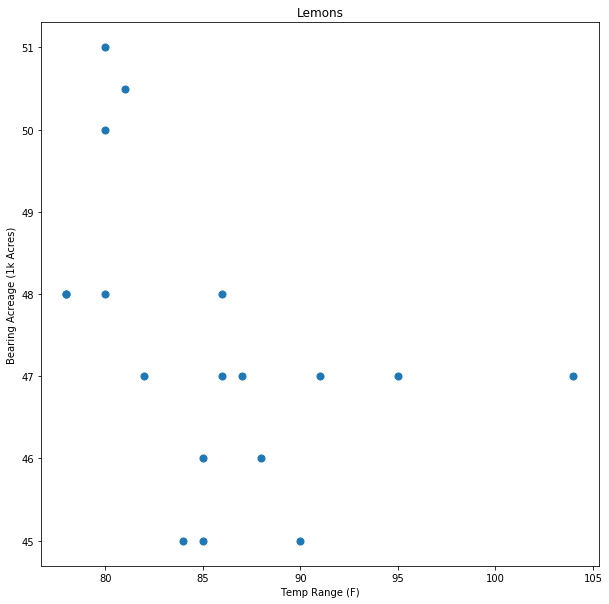

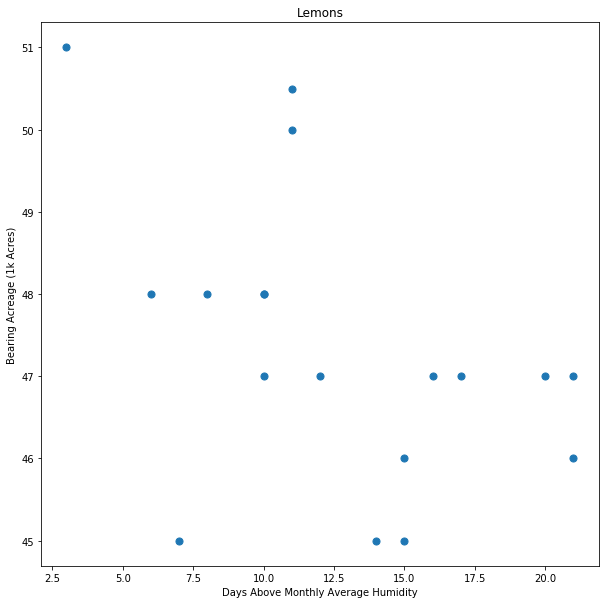

In [108]:
lemons_df.plot.scatter(x='Bearing Acreage (1k Acres)', y='Yield Per Acre (Short Tons)', s=50, title='Lemons')
lemons_df.plot.scatter(x='Days with Temp Below Freezing', y='Bearing Acreage (1k Acres)', s=50, title='Lemons')
lemons_df.plot.scatter(x='Days Below Average Temp', y='Yield Per Acre (Short Tons)', s=50, title='Lemons')
lemons_df.plot.scatter(x='Days Below Average Temp', y='Production (1k Short Tons)', s=50, title='Lemons')
lemons_df.plot.scatter(x='Temp Range (F)', y='Bearing Acreage (1k Acres)', s=50, title='Lemons')
lemons_df.plot.scatter(x='Days Above Monthly Average Humidity', y='Bearing Acreage (1k Acres)', s=50, title='Lemons')

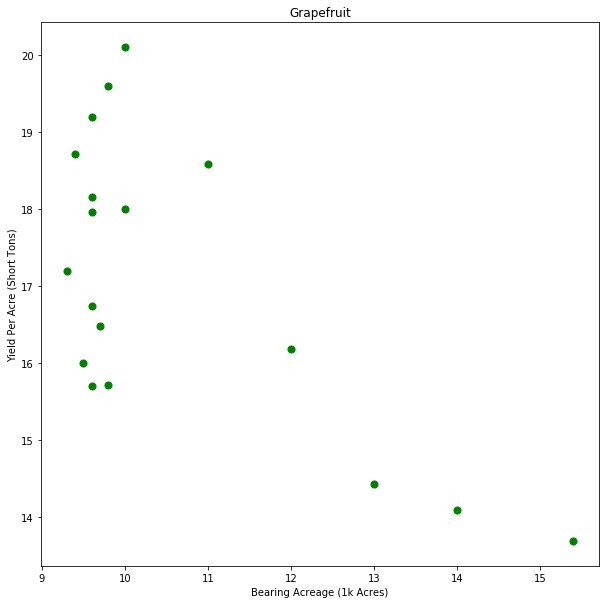

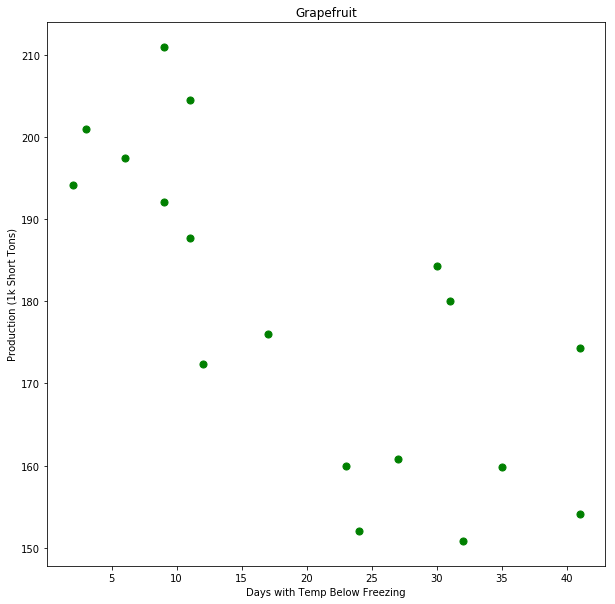

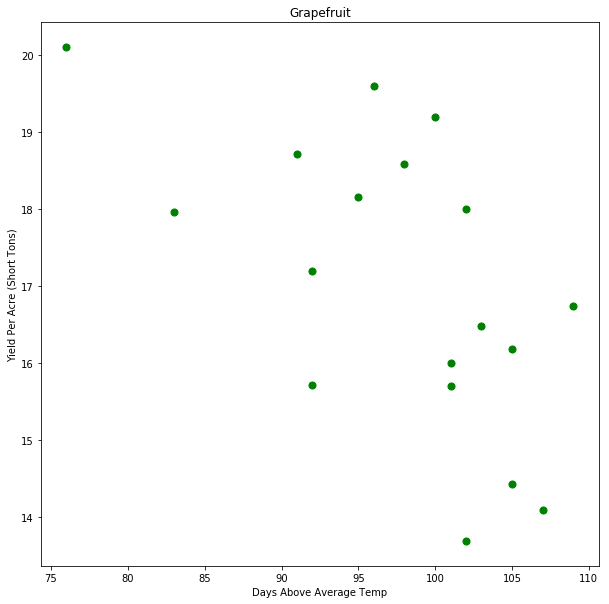

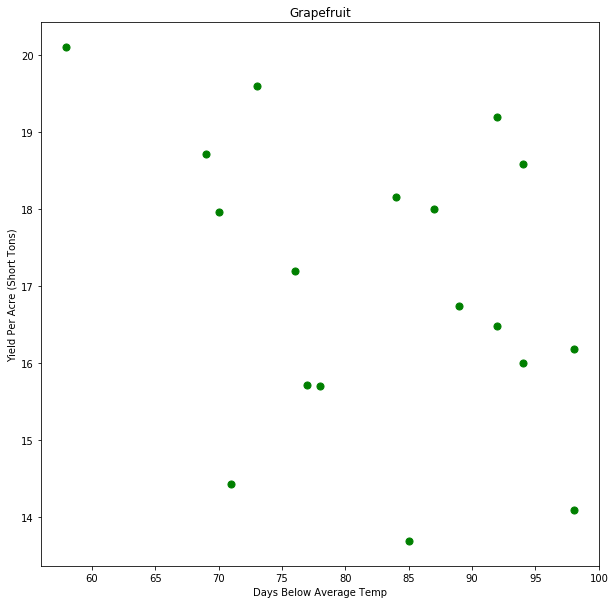

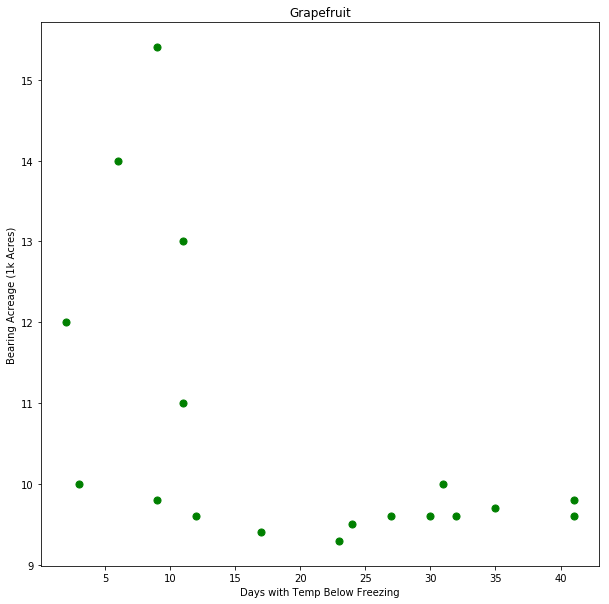

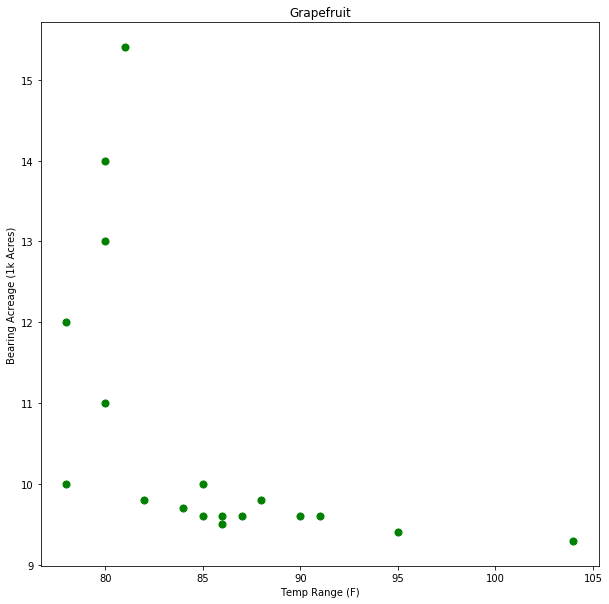

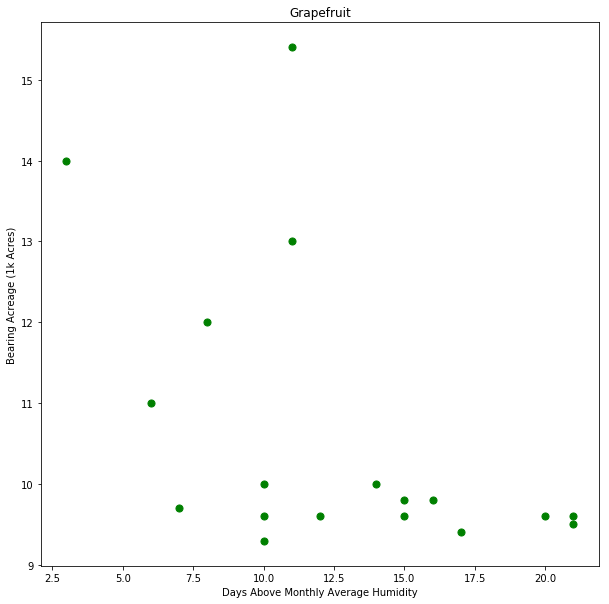

In [106]:
grapefruit_df.plot.scatter(x='Bearing Acreage (1k Acres)', y='Yield Per Acre (Short Tons)', s=50, c='green', title='Grapefruit')
grapefruit_df.plot.scatter(x='Days with Temp Below Freezing', y='Production (1k Short Tons)', s=50, c='green', title='Grapefruit')
grapefruit_df.plot.scatter(x='Days Above Average Temp', y='Yield Per Acre (Short Tons)', s=50, c='green', title='Grapefruit')
grapefruit_df.plot.scatter(x='Days Below Average Temp', y='Yield Per Acre (Short Tons)', s=50, c='green', title='Grapefruit')
grapefruit_df.plot.scatter(x='Days with Temp Below Freezing', y='Bearing Acreage (1k Acres)', s=50, c='green', title='Grapefruit')
grapefruit_df.plot.scatter(x='Temp Range (F)', y='Bearing Acreage (1k Acres)', s=50, c='green', title='Grapefruit')
grapefruit_df.plot.scatter(x='Days Above Monthly Average Humidity', y='Bearing Acreage (1k Acres)', s=50, c='green', title='Grapefruit')

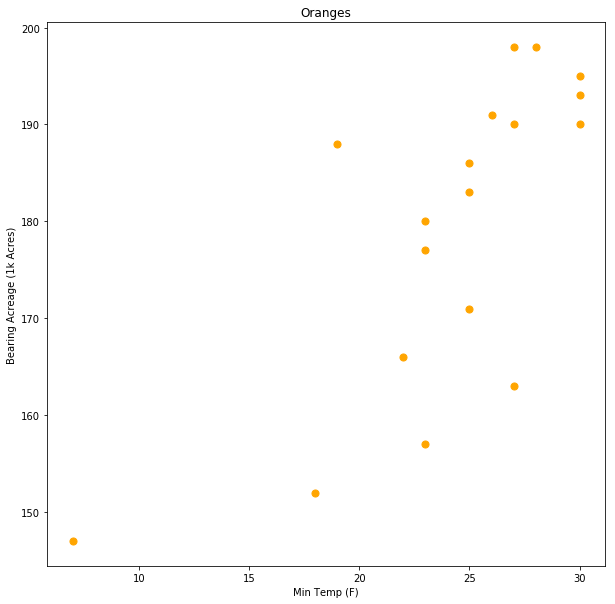

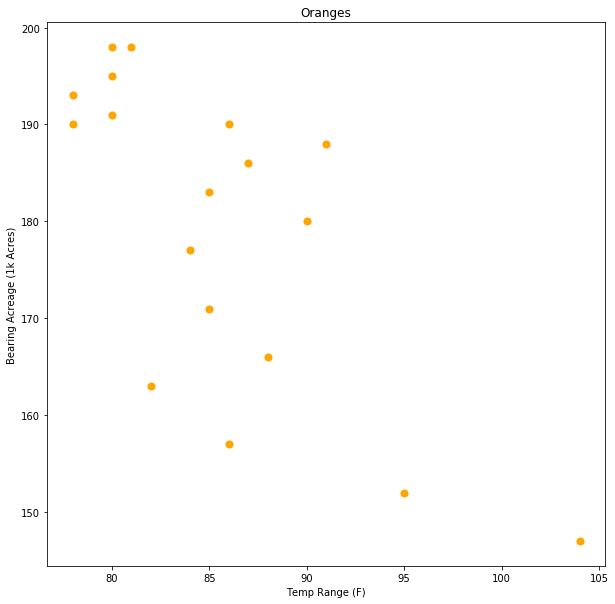

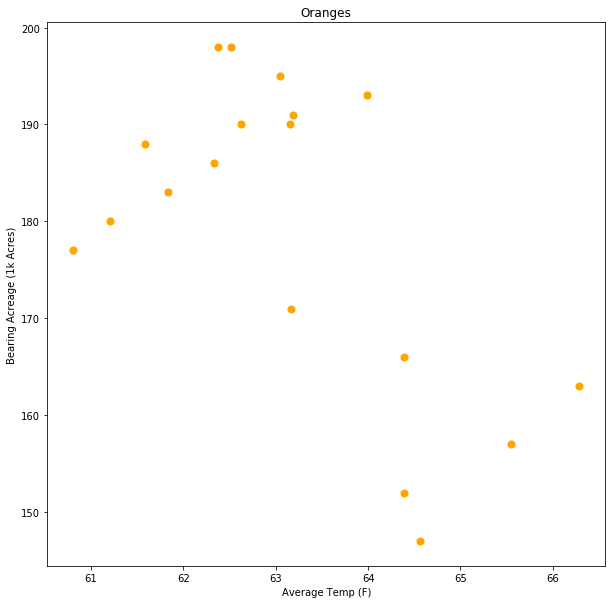

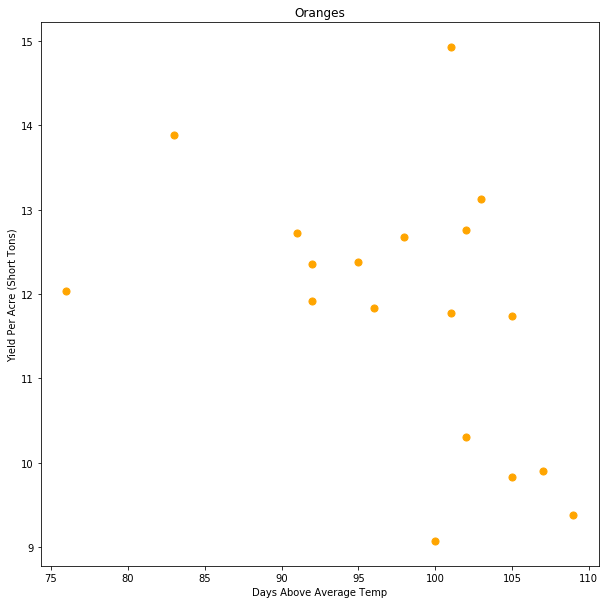

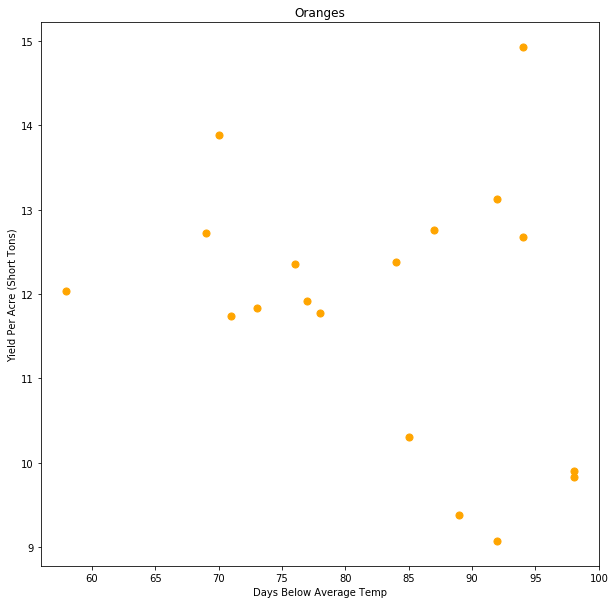

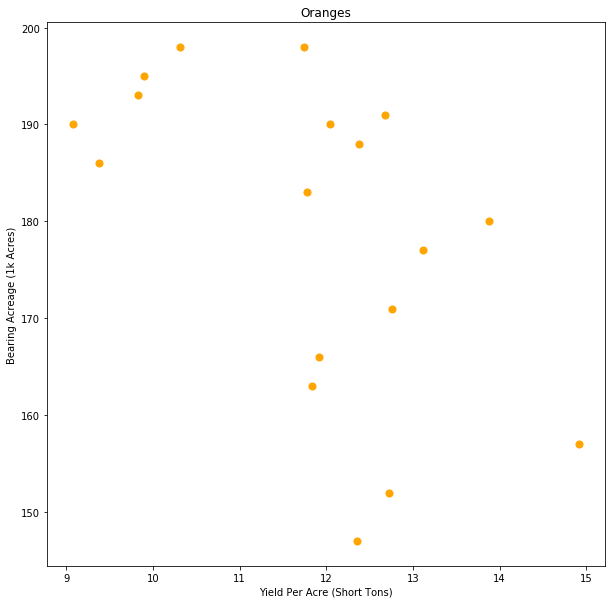

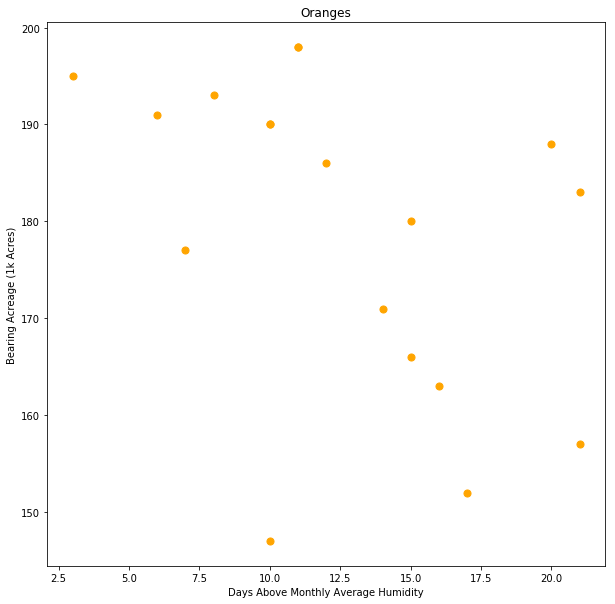

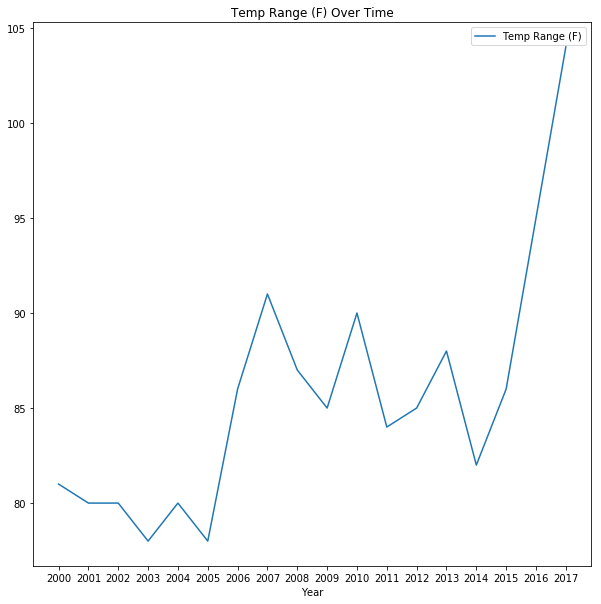

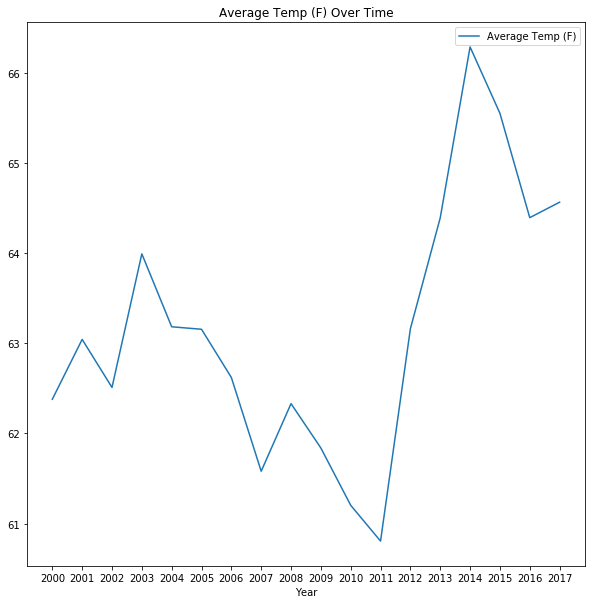

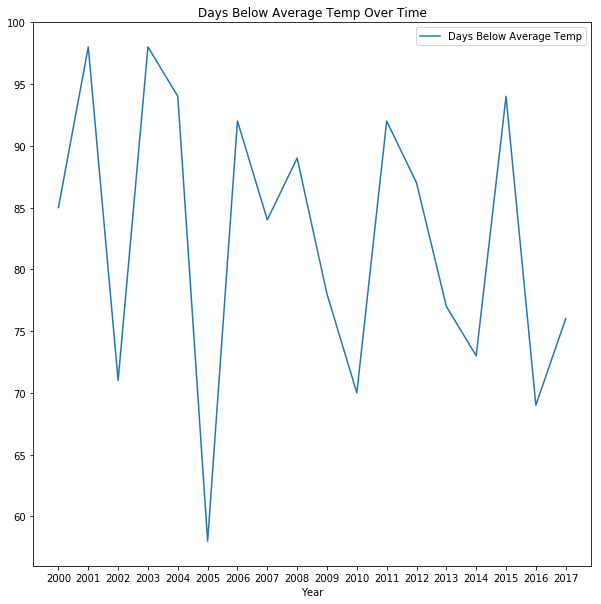

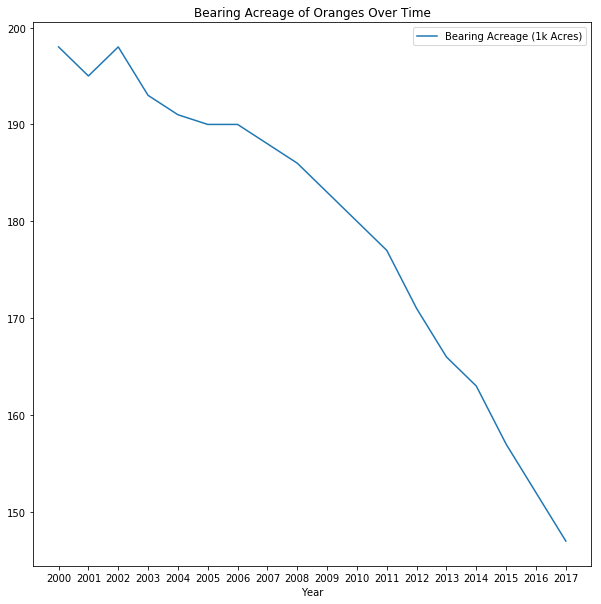

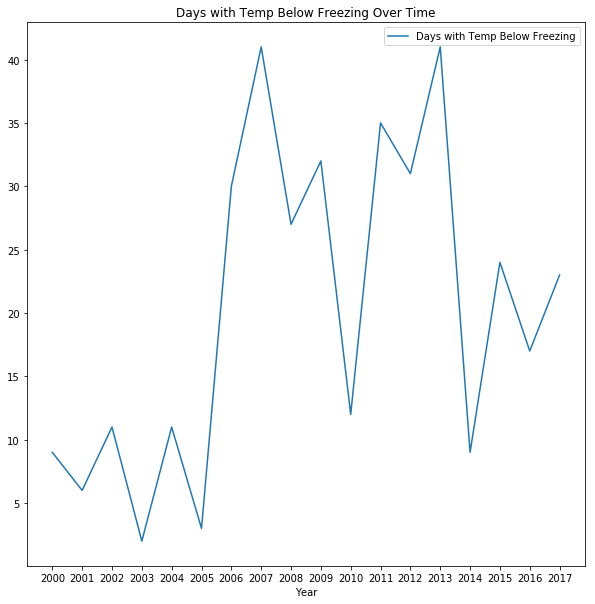

In [107]:
oranges_df.plot.scatter(x='Min Temp (F)', y='Bearing Acreage (1k Acres)', s=50, c='orange', title='Oranges')
oranges_df.plot.scatter(x='Temp Range (F)', y='Bearing Acreage (1k Acres)', s=50, c='orange', title='Oranges')
oranges_df.plot.scatter(x='Average Temp (F)', y='Bearing Acreage (1k Acres)', s=50, c='orange', title='Oranges')
oranges_df.plot.scatter(x='Days Above Average Temp', y='Yield Per Acre (Short Tons)', s=50, c='orange', title='Oranges')
oranges_df.plot.scatter(x='Days Below Average Temp', y='Yield Per Acre (Short Tons)', s=50, c='orange', title='Oranges')
oranges_df.plot.scatter(x='Yield Per Acre (Short Tons)', y='Bearing Acreage (1k Acres)', s=50, c='orange', title='Oranges')
oranges_df.plot.scatter(x='Days Above Monthly Average Humidity', y='Bearing Acreage (1k Acres)', s=50, c='orange', title='Oranges')

# Some time series plots to show trends over time in some of the temperature/humidity metrics
oranges_df.plot.line(x='Year', y='Temp Range (F)', xticks=years, title='Temp Range (F) Over Time')
oranges_df.plot.line(x='Year', y='Average Temp (F)', xticks=years, title='Average Temp (F) Over Time')
oranges_df.plot.line(x='Year', y='Days Below Average Temp', xticks=years, title='Days Below Average Temp Over Time')
oranges_df.plot.line(x='Year', y='Bearing Acreage (1k Acres)', xticks=years, title='Bearing Acreage of Oranges Over Time')
oranges_df.plot.line(x='Year', y='Days with Temp Below Freezing', xticks=years, title='Days with Temp Below Freezing Over Time')

In [57]:
days_with_temp_below_32_previous_season = []
days_with_temp_below_current_season = []
days_with_temp_below_monthly_current_season = []

print(california_daily_averages[:2])

for year, ytemp, _ in california_yearly_averages:
    if int(year) < 2018:
        seasonal_temps = [
            temp for (date, temp, humidity) in california_daily_averages
            if date >= year + '-11-01' and date <= str(int(year) + 1) + '-10-31'
        ]
        sum_temps = sum([temp for temp in seasonal_temps])
        avg_temp = sum_temps / len(seasonal_temps)
        days_below = len([temp for temp in seasonal_temps if temp < avg_temp - 10])
        days_with_temp_below_current_season.append(days_below)

for year, ytemp, _ in california_yearly_averages:
    if int(year) < 2018:
        monthly_temps = [
            (month, temp) for (month, temp, _) in california_monthly_averages
            if month >= year + '-11' and month <= str(int(year) + 1) + '-10'
        ]
        num_days = 0
        for month, mtemp in monthly_temps:
            daily_temps = [
                temp for (date, temp, humidity) 
                in california_daily_averages 
                if temp < mtemp - 7 and date[:7] == month]
            num_days += len(daily_temps)
        days_with_temp_below_monthly_current_season.append(num_days)

print(days_with_temp_below_current_season)
print(days_with_temp_below_monthly_current_season)

[('2000-01-01', 46.03125, 68.125), ('2000-01-02', 43.752941176470586, 77.7764705882353)]
[116, 86, 100, 94, 71, 90, 86, 101, 83, 83, 87, 106, 83, 85, 73, 79, 83, 77]
[10, 22, 16, 25, 12, 21, 26, 14, 12, 14, 25, 16, 23, 23, 27, 19, 29, 15]


In [65]:


grapefruit_data_dict_improved = {
    'Year': years,
    'Yield Per Acre (Short Tons)': ypa_grapefruit,
    'Bearing Acreage (1k Acres)': ba_grapefruit,
    'Production (1k Short Tons)': prod_grapefruit,
    'Days Temp Below Seasonal Average': days_with_temp_below_current_season,
    'Days Temp Below Monthly Average in Season': days_with_temp_below_monthly_current_season,
}

oranges_data_dict_improved = {
    'Year': years,
    'Yield Per Acre (Short Tons)': ypa_oranges,
    'Bearing Acreage (1k Acres)': ba_oranges,
    'Production (1k Short Tons)': prod_oranges,
    'Days Temp Below Seasonal Average': days_with_temp_below_current_season,
    'Days Temp Below Monthly Average in Season': days_with_temp_below_monthly_current_season,
}

lemons_data_dict_improved = {
    'Year': years,
    'Yield Per Acre (Short Tons)': ypa_lemons,
    'Bearing Acreage (1k Acres)': ba_lemons,
    'Production (1k Short Tons)': prod_lemons,
    'Days Temp Below Seasonal Average': days_with_temp_below_current_season,
    'Days Temp Below Monthly Average in Season': days_with_temp_below_monthly_current_season,
}


grapefruit_df_improved = pd.DataFrame.from_dict(grapefruit_data_dict_improved)
grapefruit_df_improved

print(grapefruit_df_improved.corr()[['Yield Per Acre (Short Tons)', 'Bearing Acreage (1k Acres)', 'Production (1k Short Tons)']])

oranges_df_improved = pd.DataFrame.from_dict(oranges_data_dict_improved)
oranges_df_improved

print(oranges_df_improved.corr()[['Yield Per Acre (Short Tons)', 'Bearing Acreage (1k Acres)', 'Production (1k Short Tons)']])

lemons_df_improved = pd.DataFrame.from_dict(lemons_data_dict_improved)
lemons_df_improved

print(lemons_df_improved.corr()[['Yield Per Acre (Short Tons)', 'Bearing Acreage (1k Acres)', 'Production (1k Short Tons)']])

                                           Yield Per Acre (Short Tons)  \
Yield Per Acre (Short Tons)                                   1.000000   
Bearing Acreage (1k Acres)                                   -0.681914   
Production (1k Short Tons)                                    0.082579   
Days Temp Below Seasonal Average                             -0.472337   
Days Temp Below Monthly Average in Season                     0.420007   

                                           Bearing Acreage (1k Acres)  \
Yield Per Acre (Short Tons)                                 -0.681914   
Bearing Acreage (1k Acres)                                   1.000000   
Production (1k Short Tons)                                   0.669099   
Days Temp Below Seasonal Average                             0.531536   
Days Temp Below Monthly Average in Season                   -0.266960   

                                           Production (1k Short Tons)  
Yield Per Acre (Short Tons)                 

In [ ]:
# days in which the temperature was 10 degrees or more below the yearly average, and 10 degrees or more above the yearly average
for year, ytemp, yhumidity in california_yearly_averages:
    current_year = [year]
    
    days_below = [(date, temp, humidity) for (date, temp, humidity) in california_daily_averages if date[:4] == year and temp < ytemp - 10]
    days_below_yearly_average_temp.append(current_year + [len(days_below)])
    
    days_above = [(date, temp, humidity) for (date, temp, humidity) in california_daily_averages if date[:4] == year and temp > ytemp + 10]
    days_above_yearly_average_temp.append(current_year + [len(days_above)])

print(days_above_yearly_average_temp)
print(days_below_yearly_average_temp)

monthly_lows_dict = dict([(year, 0) for (year, temp, humidity) in california_yearly_averages])
monthly_highs_dict = dict([(year, 0) for (year, temp, humidity) in california_yearly_averages])

# days in which the temperature was 7 degrees or more below the monthly average, and 7 degrees or more above the monthly average
for month, mtemp, mhumidity in california_monthly_averages:
    days_below = [(date, temp, humidity) for (date, temp, humidity) in california_daily_averages if date[:7] == month and temp < mtemp - 7]
    days_above = [(date, temp, humidity) for (date, temp, humidity) in california_daily_averages if date[:7] == month and temp > mtemp + 7]
    
    monthly_lows_dict[month[:4]] += len(days_below)
    monthly_highs_dict[month[:4]] += len(days_above)

print(monthly_lows_dict)
print(monthly_highs_dict)

# number of days in which the min temperature was within 3 degrees of the monthly low, with a monthly low < 32, by year
monthly_extremes_dict = dict([(year, 0) for (year, _, _) in california_yearly_averages])

for month, mtemp, mhumidity in california_monthly_min:
    
    days_within_range = [(date, temp, _) for (date, temp, _) in california_daily_min if date[:7] == month and temp < mtemp + 3 and mtemp < 32]
    monthly_extremes_dict[month[:4]] += len(days_within_range)

print(monthly_extremes_dict)

# days in which the average humidity was 15% or more above the monthly average, grouped by year
monthly_humidity_highs_dict = dict([(year, 0) for (year, _, _) in california_yearly_averages])

for month, _, mhumidity in california_monthly_averages:
    days_above = [(date, _, humidity) for (date, _, humidity) in california_daily_averages if date[:7] == month and humidity >= mhumidity + 15]
    monthly_humidity_highs_dict[month[:4]] += len(days_above)

print(monthly_humidity_highs_dict)

# days in which the average humidity was 25% or more above the yearly average, grouped by year
yearly_humidity_highs_dict = dict([(year, 0) for (year, _, _) in california_yearly_averages])

for year, _, yhumidity in california_yearly_averages:
    days_above = [(date, _, humidity) for (date, _, humidity) in california_daily_averages if date[:4] == year and humidity >= yhumidity + 25]
    yearly_humidity_highs_dict[year] += len(days_above)

print(yearly_humidity_highs_dict)
    
# days in which the minimum temperature was below 32 degrees fahrenheit
for year, ytemp, yhumidity in california_yearly_averages:
    current_year = [year]
    
    days_below = [(date, temp, humidity) for (date, temp, humidity) in california_daily_min if date[:4] == year and temp < 32]
    days_min_temp_below_32.append(current_year + [len(days_below)])
print(days_min_temp_below_32)

True